The text in the document by Shujie Fan, Jing Yang, Zhiwei Zhang is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document by Shujie Fan, Jing Yang, Zhiwei Zhang is licensed under the MIT License https://opensource.org/licenses/MIT<br>
https://github.com/shujiefan/7390/blob/master/LICENSE

<h1>Digit Recognition</h1>
<br>
<strong>Dataset Description:</strong>
train.csv (42000 rows and 785 columns, columns are composed of one digit label and 784 pixels values of digit images)
test.csv (28000 rows and 784 columns, columns are composed of 784 pixels values of digit images)<br>

<h1>CNN</h1>
<p>A convolutional neural network (CNN, or ConvNet) is a class of deep, feed-forward artificial neural networks that has successfully been applied to analyzing visual imagery.</p>

<p>CNNs use a variation of multilayer perceptrons designed to require minimal preprocessing. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics.</p>

<p>Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.</p>

<p>CNNs use relatively little pre-processing compared to other image classification algorithms. This means that the network learns the filters that in traditional algorithms were hand-engineered. This independence from prior knowledge and human effort in feature design is a major advantage.</p>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import time 

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import *

In [3]:
sns.set(style='white', context='notebook', palette='deep')

<h2>1.Data Preparation</h2>

<h3>1.1 Load the data</h3>

By Shujie Fan, is licensed under the MIT License https://opensource.org/licenses/MIT<br>
https://github.com/shujiefan/7390/blob/master/LICENSE

In [41]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<h3>1.2 Null and Missing Values</h3> <br>
We can see below, that is no missing values

In [42]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [43]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

labels = Y_train.value_counts()
labels

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

We can see from the picture drawn below, the training dataset distributed evenly, so we don't need to make some changes to it.

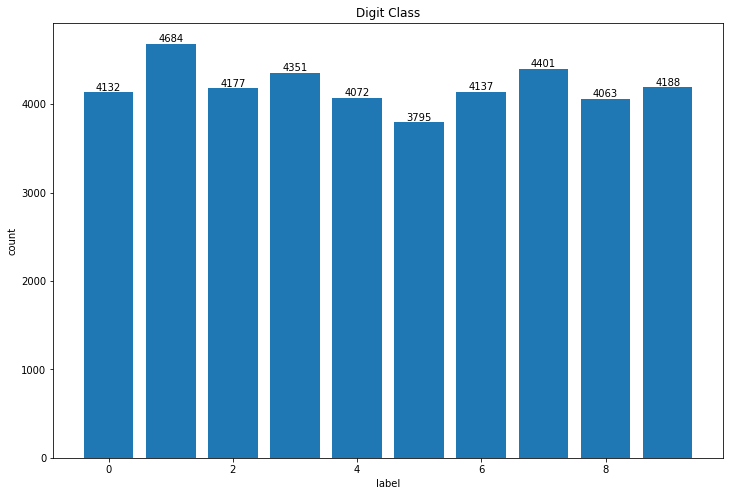

In [9]:
# Plot the label counts
count = labels.values.tolist()
classes = labels.axes[0].tolist()

fig = plt.figure(figsize=(12,8))
class_bar = plt.bar(classes, count)
plt.xlabel("label")  
plt.ylabel("count")  
plt.title("Digit Class")  

# add the exact value on top of the bar
def autolabel(rects,fontsize=10):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
autolabel(class_bar)
  
plt.show()

<h3>1.3 split the data to train and test dataset</h3>

In [10]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state=random_seed)

In [12]:
# Download the train and test set to csv files
X_train.to_csv('X_trainn.csv')
Y_train.to_csv('Y_trainn.csv')
X_val.to_csv('X_vall.csv')
Y_val.to_csv('Y_vall.csv')

<h3>1.4 Data Normalization</h3> <br>
<p>The original value is [0,255]</p>
<p>To make training less sensitive to the scale of features and also to make the model converg faster, we do data normalization</p>

In [16]:
X_train = X_train / 255.0
X_val = X_val / 255.0
test = test / 255.0

<h3>1.5 Reshape all data to 28x28x1 3D matrices</h3> <br>
<p>Keras requires an extra dimension in the end which correspond to channels. </p>

In [17]:
X_train.shape

(29400, 784)

In [18]:
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

<h3>1.6 Label encoding</h3>
<p>We often do label encoding when the property to be predict is string type, in this project, our label to be predicted is numerical type, so this process is actually not the necessary part for our project. While some optimizers requires one hot encoding, so we still add this process.</p>

In [21]:
# to one hot encoding
Y_train = to_categorical(Y_train, num_classes = 10)
Y_val = to_categorical(Y_val, num_classes = 10)

<h2>2.Model Selection</h2> <br>
<h3>2.1 CNN </h3>

<p>In our project, we first compared activation function, find the one with highest accuracy, and then use this activation function for the following part. We have used ReLu, tanH, sigmoid, elu, selu, softplus, softsign, hard_sigmoid, linear activation functions, after testing, we found out when using ReLu, we got the highest accuracy, so we then applied ReLu as our activation functions both on our convolutional layers and dense layers.</p>
<p>Secondly, we compared cost functions. We have used categorical_crossentropy, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_logarithmic_error, squared_hinge, hinge, categorical_hinge, logcosh, sparse_categorical_crossentropy, binary_crossentropy, kullback_leibler_divergence, poisson, and binary_crossentropy helps us maintain the highest accuracy.</p>
<p>Thirdly, we compared Optimizer. Our model has been trained with RMSprop, SGD, Adagrad, Adadelta, Adam, Adamax, Nadam optimizer. Based on our training result, Nadam optimizer got the best performance.</p>
<p>Fourthly, we compared initializer. In our research, we used uniform, lecun_uniform, normal, glorot_normal, he_normal, it seems that different kernel initializer didn’t make a significant change to the performance, but we still applied the one with slightly better performance for initialization, it’s ‘glorot_normal’ and 'lecun_uniform' kernel initializer. In the following part, we will use ‘glorot_normal’ as our initializer.</p>
<p>Fifthly, we compared kernel_size, we have used 3*3, 5*5, 8*8, and found out 5*5 get the best result.</p>
<p>Sixthly, we compared filters, we have used 16, 32, 64 as its value, and found out when using 32 in the first two convolutional layers, we can get the best result.</p>
<p>Seventhly, we compared different network architectures, we have tried to add a BatchNormalization layer, change the pooling layer from MaxPool to AveragePooling, add one or two convolutional layers, delete one or two convolutional layers, still model36 get the best result.</p>
<p>Eighthly, we compared different dropout values, we tried to set the dropout value to 0, 0.25, 0.5, 0.75, and 0.25 get the highest accuracy.</p>
<p>Lastly, we compared different learning rate values, we tried different learning rate values, we have used 0.001, 0.01, 0.1, and 0.001 achieved the highest accuracy.</p>

<h3>Compare activations function</h3>

Activation function is just a node that you add to the output end of any neural network. It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

#model1 use relu

By Jing Yang, is licensed under the MIT License https://opensource.org/licenses/MIT

In [21]:
# Build the model
model = Sequential()
# the first layer should provide input_shape
conv1 = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1))
conv2 = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')
model.add(conv1)
model.add(conv2)
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


conv3 = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')
conv4 = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')
model.add(conv3)
model.add(conv4)
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [22]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical.<br>
We have already done that step above.

In [23]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In order to make the optimizer converge faster and closest to the global minimum of the loss function, we used an annealing method of the learning rate (LR).<br>

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.<br>

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.<br>

To keep the advantage of the fast computation time with a high LR, we decreased the LR dynamically by half every 3 steps (epochs) depending if it is necessary (when accuracy is not improved).

In [25]:
# decreased the LR dynamically by half every 3 steps (epochs) depending if it is necessary (when accuracy is not improved).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
epochs = 20
batch_size = 86

<strong>Data augmentation</strong>
To prevent overfitting problems.

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [30]:
t1=time.time()
# fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 

Epoch 1/20
 - 212s - loss: 0.1097 - acc: 0.9675 - val_loss: 0.0512 - val_acc: 0.9857
Epoch 2/20
 - 224s - loss: 0.0907 - acc: 0.9736 - val_loss: 0.0349 - val_acc: 0.9892
Epoch 3/20
 - 215s - loss: 0.0811 - acc: 0.9758 - val_loss: 0.0434 - val_acc: 0.9879
Epoch 4/20
 - 216s - loss: 0.0744 - acc: 0.9782 - val_loss: 0.0347 - val_acc: 0.9900
Epoch 5/20
 - 214s - loss: 0.0677 - acc: 0.9805 - val_loss: 0.0295 - val_acc: 0.9917
Epoch 6/20
 - 220s - loss: 0.0655 - acc: 0.9814 - val_loss: 0.0297 - val_acc: 0.9920
Epoch 7/20
 - 232s - loss: 0.0655 - acc: 0.9818 - val_loss: 0.0285 - val_acc: 0.9912
Epoch 8/20
 - 233s - loss: 0.0600 - acc: 0.9825 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 9/20
 - 234s - loss: 0.0617 - acc: 0.9823 - val_loss: 0.0256 - val_acc: 0.9925
Epoch 10/20
 - 235s - loss: 0.0613 - acc: 0.9831 - val_loss: 0.0340 - val_acc: 0.9912
Epoch 11/20
 - 231s - loss: 0.0592 - acc: 0.9839 - val_loss: 0.0396 - val_acc: 0.9901
Epoch 12/20
 - 222s - loss: 0.0606 - acc: 0.9829 - val_loss: 0.

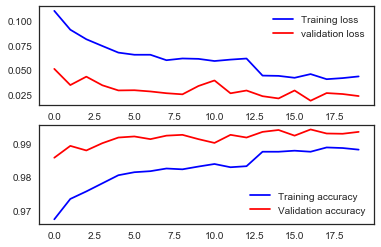

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [32]:
# evaluate the result
score = model.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

validation loss: 0.0238357168668
validation accuracy: 0.993333333333


#model2 use tanh

In [33]:
# Build the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='tanh', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='tanh'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='tanh'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='tanh'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [34]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [35]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [37]:
epochs = 20
batch_size = 86

In [38]:
t1=time.time()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 

Epoch 1/20
 - 202s - loss: 0.5826 - acc: 0.8187 - val_loss: 0.1207 - val_acc: 0.9603
Epoch 2/20
 - 202s - loss: 0.2097 - acc: 0.9344 - val_loss: 0.0595 - val_acc: 0.9821
Epoch 3/20
 - 205s - loss: 0.1646 - acc: 0.9492 - val_loss: 0.0507 - val_acc: 0.9833
Epoch 4/20
 - 225s - loss: 0.1423 - acc: 0.9550 - val_loss: 0.0514 - val_acc: 0.9838
Epoch 5/20
 - 234s - loss: 0.1327 - acc: 0.9602 - val_loss: 0.0507 - val_acc: 0.9838
Epoch 6/20
 - 228s - loss: 0.1198 - acc: 0.9638 - val_loss: 0.0491 - val_acc: 0.9844
Epoch 7/20
 - 238s - loss: 0.1126 - acc: 0.9664 - val_loss: 0.0583 - val_acc: 0.9821
Epoch 8/20
 - 241s - loss: 0.1059 - acc: 0.9674 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 9/20
 - 230s - loss: 0.1024 - acc: 0.9703 - val_loss: 0.0375 - val_acc: 0.9885
Epoch 10/20
 - 221s - loss: 0.0983 - acc: 0.9701 - val_loss: 0.0429 - val_acc: 0.9867
Epoch 11/20
 - 217s - loss: 0.0936 - acc: 0.9703 - val_loss: 0.0392 - val_acc: 0.9879
Epoch 12/20
 - 214s - loss: 0.0926 - acc: 0.9716 - val_loss: 0.

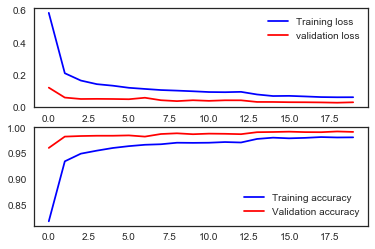

In [39]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [40]:
score = model.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

validation loss: 0.0302546483459
validation accuracy: 0.991190476153


#model3 sigmoid

In [41]:
# Build the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='sigmoid', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='sigmoid'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='sigmoid'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='sigmoid'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [42]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [43]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [45]:
epochs = 20
batch_size = 86

In [46]:
t1=time.time()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 

Epoch 1/20
 - 221s - loss: 2.3299 - acc: 0.1063 - val_loss: 2.3012 - val_acc: 0.1147
Epoch 2/20
 - 220s - loss: 2.0684 - acc: 0.2251 - val_loss: 1.0483 - val_acc: 0.6919
Epoch 3/20
 - 210s - loss: 0.9947 - acc: 0.6685 - val_loss: 0.2748 - val_acc: 0.9279
Epoch 4/20
 - 200s - loss: 0.4011 - acc: 0.8753 - val_loss: 0.1363 - val_acc: 0.9622
Epoch 5/20
 - 200s - loss: 0.2463 - acc: 0.9244 - val_loss: 0.1057 - val_acc: 0.9653
Epoch 6/20
 - 200s - loss: 0.1926 - acc: 0.9419 - val_loss: 0.0755 - val_acc: 0.9771
Epoch 7/20
 - 200s - loss: 0.1686 - acc: 0.9477 - val_loss: 0.0688 - val_acc: 0.9787
Epoch 8/20
 - 200s - loss: 0.1431 - acc: 0.9577 - val_loss: 0.0655 - val_acc: 0.9790
Epoch 9/20
 - 200s - loss: 0.1331 - acc: 0.9588 - val_loss: 0.0543 - val_acc: 0.9832
Epoch 10/20
 - 200s - loss: 0.1243 - acc: 0.9632 - val_loss: 0.0509 - val_acc: 0.9838
Epoch 11/20
 - 200s - loss: 0.1137 - acc: 0.9667 - val_loss: 0.0451 - val_acc: 0.9860
Epoch 12/20
 - 200s - loss: 0.1125 - acc: 0.9663 - val_loss: 0.

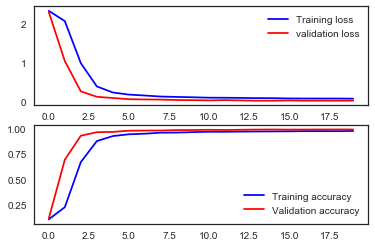

In [47]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [48]:
score = model.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

validation loss: 0.0376014414713
validation accuracy: 0.989047619048


#model4 elu

Epoch 1/20
 - 213s - loss: 0.4906 - acc: 0.8452 - val_loss: 0.0884 - val_acc: 0.9715
Epoch 2/20
 - 223s - loss: 0.2313 - acc: 0.9302 - val_loss: 0.0716 - val_acc: 0.9788
Epoch 3/20
 - 223s - loss: 0.1882 - acc: 0.9465 - val_loss: 0.0485 - val_acc: 0.9853
Epoch 4/20
 - 225s - loss: 0.1569 - acc: 0.9558 - val_loss: 0.0504 - val_acc: 0.9863
Epoch 5/20
 - 228s - loss: 0.1447 - acc: 0.9596 - val_loss: 0.0519 - val_acc: 0.9840
Epoch 6/20
 - 273s - loss: 0.1332 - acc: 0.9635 - val_loss: 0.0494 - val_acc: 0.9858
Epoch 7/20
 - 258s - loss: 0.1328 - acc: 0.9633 - val_loss: 0.0420 - val_acc: 0.9877
Epoch 8/20
 - 235s - loss: 0.1258 - acc: 0.9664 - val_loss: 0.0399 - val_acc: 0.9887
Epoch 9/20
 - 208s - loss: 0.1246 - acc: 0.9665 - val_loss: 0.0452 - val_acc: 0.9871
Epoch 10/20
 - 204s - loss: 0.1162 - acc: 0.9694 - val_loss: 0.0405 - val_acc: 0.9897
Epoch 11/20
 - 204s - loss: 0.1105 - acc: 0.9704 - val_loss: 0.0395 - val_acc: 0.9900
Epoch 12/20
 - 203s - loss: 0.1098 - acc: 0.9719 - val_loss: 0.

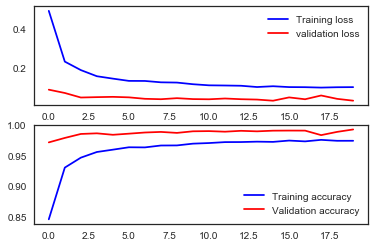

In [49]:
# Build the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='elu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='elu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='elu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "elu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model5 selu

Epoch 1/20
 - 237s - loss: 0.7478 - acc: 0.7820 - val_loss: 0.1186 - val_acc: 0.9641
Epoch 2/20
 - 278s - loss: 0.3456 - acc: 0.8988 - val_loss: 0.0974 - val_acc: 0.9721
Epoch 3/20
 - 287s - loss: 0.2704 - acc: 0.9237 - val_loss: 0.1081 - val_acc: 0.9677
Epoch 4/20
 - 271s - loss: 0.2311 - acc: 0.9364 - val_loss: 0.0861 - val_acc: 0.9747
Epoch 5/20
 - 247s - loss: 0.1936 - acc: 0.9463 - val_loss: 0.0489 - val_acc: 0.9840
Epoch 6/20
 - 258s - loss: 0.1781 - acc: 0.9496 - val_loss: 0.0754 - val_acc: 0.9786
Epoch 7/20
 - 239s - loss: 0.1704 - acc: 0.9519 - val_loss: 0.0834 - val_acc: 0.9737
Epoch 8/20
 - 232s - loss: 0.1584 - acc: 0.9557 - val_loss: 0.0425 - val_acc: 0.9878
Epoch 9/20
 - 230s - loss: 0.1531 - acc: 0.9582 - val_loss: 0.0683 - val_acc: 0.9825
Epoch 10/20
 - 231s - loss: 0.1392 - acc: 0.9618 - val_loss: 0.0505 - val_acc: 0.9858
Epoch 11/20
 - 230s - loss: 0.1474 - acc: 0.9586 - val_loss: 0.0567 - val_acc: 0.9863
Epoch 12/20
 - 230s - loss: 0.1371 - acc: 0.9626 - val_loss: 0.

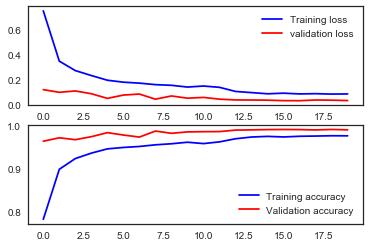

In [50]:
# Build the model
model5 = Sequential()

model5.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu', input_shape = (28,28,1)))
model5.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu'))
model5.add(MaxPool2D(pool_size=(2,2)))
model5.add(Dropout(0.25))


model5.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='selu'))
model5.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='selu'))
model5.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model5.add(Dropout(0.25))


model5.add(Flatten())
model5.add(Dense(256, activation = "selu"))
model5.add(Dropout(0.5))
model5.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model5.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model5.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model5.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model6 softplus

Epoch 1/20
 - 226s - loss: 1.7483 - acc: 0.3929 - val_loss: 0.2350 - val_acc: 0.9275
Epoch 2/20
 - 225s - loss: 0.4169 - acc: 0.8735 - val_loss: 0.1103 - val_acc: 0.9659
Epoch 3/20
 - 228s - loss: 0.2635 - acc: 0.9228 - val_loss: 0.0802 - val_acc: 0.9749
Epoch 4/20
 - 226s - loss: 0.2064 - acc: 0.9390 - val_loss: 0.0814 - val_acc: 0.9753
Epoch 5/20
 - 226s - loss: 0.1801 - acc: 0.9477 - val_loss: 0.0749 - val_acc: 0.9794
Epoch 6/20
 - 226s - loss: 0.1654 - acc: 0.9536 - val_loss: 0.0661 - val_acc: 0.9807
Epoch 7/20
 - 233s - loss: 0.1542 - acc: 0.9571 - val_loss: 0.0650 - val_acc: 0.9834
Epoch 8/20
 - 228s - loss: 0.1511 - acc: 0.9580 - val_loss: 0.0667 - val_acc: 0.9811
Epoch 9/20
 - 227s - loss: 0.1461 - acc: 0.9598 - val_loss: 0.0584 - val_acc: 0.9840
Epoch 10/20
 - 227s - loss: 0.1471 - acc: 0.9607 - val_loss: 0.0553 - val_acc: 0.9849
Epoch 11/20
 - 227s - loss: 0.1479 - acc: 0.9598 - val_loss: 0.0441 - val_acc: 0.9872
Epoch 12/20
 - 226s - loss: 0.1466 - acc: 0.9622 - val_loss: 0.

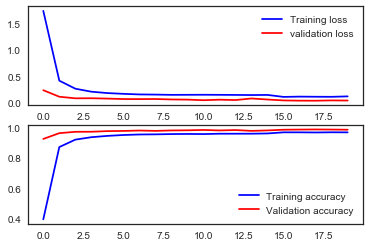

In [51]:
# Build the model
model6 = Sequential()

model6.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='softplus', input_shape = (28,28,1)))
model6.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='softplus'))
model6.add(MaxPool2D(pool_size=(2,2)))
model6.add(Dropout(0.25))


model6.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='softplus'))
model6.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='softplus'))
model6.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model6.add(Dropout(0.25))


model6.add(Flatten())
model6.add(Dense(256, activation = "softplus"))
model6.add(Dropout(0.5))
model6.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model6.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model6.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model6.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model7 softsign

Epoch 1/20
 - 210s - loss: 0.4307 - acc: 0.8610 - val_loss: 0.0983 - val_acc: 0.9697
Epoch 2/20
 - 210s - loss: 0.1934 - acc: 0.9409 - val_loss: 0.0747 - val_acc: 0.9782
Epoch 3/20
 - 210s - loss: 0.1532 - acc: 0.9547 - val_loss: 0.0561 - val_acc: 0.9825
Epoch 4/20
 - 210s - loss: 0.1356 - acc: 0.9588 - val_loss: 0.0545 - val_acc: 0.9846
Epoch 5/20
 - 210s - loss: 0.1217 - acc: 0.9627 - val_loss: 0.0487 - val_acc: 0.9844
Epoch 6/20
 - 210s - loss: 0.1113 - acc: 0.9659 - val_loss: 0.0549 - val_acc: 0.9831
Epoch 7/20
 - 210s - loss: 0.1029 - acc: 0.9681 - val_loss: 0.0403 - val_acc: 0.9879
Epoch 8/20
 - 210s - loss: 0.1015 - acc: 0.9696 - val_loss: 0.0455 - val_acc: 0.9863
Epoch 9/20
 - 210s - loss: 0.0965 - acc: 0.9706 - val_loss: 0.0414 - val_acc: 0.9873
Epoch 10/20
 - 209s - loss: 0.0928 - acc: 0.9729 - val_loss: 0.0406 - val_acc: 0.9867
Epoch 11/20
 - 210s - loss: 0.0870 - acc: 0.9735 - val_loss: 0.0358 - val_acc: 0.9891
Epoch 12/20
 - 210s - loss: 0.0779 - acc: 0.9752 - val_loss: 0.

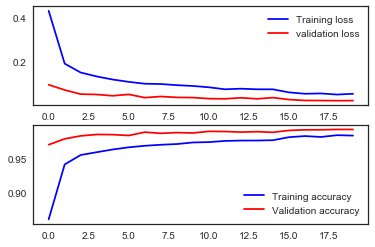

In [52]:
# Build the model
model7 = Sequential()

model7.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='softsign', input_shape = (28,28,1)))
model7.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='softsign'))
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.25))


model7.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='softsign'))
model7.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='softsign'))
model7.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model7.add(Dropout(0.25))


model7.add(Flatten())
model7.add(Dense(256, activation = "softsign"))
model7.add(Dropout(0.5))
model7.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model7.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model7.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model7.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model8 hard_sigmoid

Epoch 1/20
 - 261s - loss: 2.3679 - acc: 0.1010 - val_loss: 2.3059 - val_acc: 0.0943
Epoch 2/20
 - 250s - loss: 2.3067 - acc: 0.1036 - val_loss: 2.3011 - val_acc: 0.1147
Epoch 3/20
 - 260s - loss: 2.3040 - acc: 0.1058 - val_loss: 2.3020 - val_acc: 0.1039
Epoch 4/20
 - 266s - loss: 2.3026 - acc: 0.1056 - val_loss: 2.3016 - val_acc: 0.1147
Epoch 5/20
 - 259s - loss: 2.3026 - acc: 0.1062 - val_loss: 2.3016 - val_acc: 0.1147
Epoch 6/20
 - 221s - loss: 2.3030 - acc: 0.1074 - val_loss: 2.3012 - val_acc: 0.1147

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
 - 220s - loss: 2.3023 - acc: 0.1059 - val_loss: 2.3012 - val_acc: 0.1147
Epoch 8/20
 - 219s - loss: 2.3021 - acc: 0.1086 - val_loss: 2.3011 - val_acc: 0.1147
Epoch 9/20
 - 219s - loss: 2.3021 - acc: 0.1066 - val_loss: 2.3009 - val_acc: 0.1147

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/20
 - 221s - loss: 2.3021 - acc: 0.1105 - val_loss: 2.3010 - val

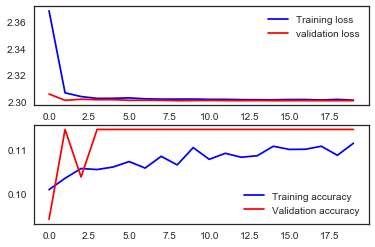

In [53]:
# Build the model
model8 = Sequential()

model8.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='hard_sigmoid', input_shape = (28,28,1)))
model8.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='hard_sigmoid'))
model8.add(MaxPool2D(pool_size=(2,2)))
model8.add(Dropout(0.25))


model8.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='hard_sigmoid'))
model8.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='hard_sigmoid'))
model8.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model8.add(Dropout(0.25))


model8.add(Flatten())
model8.add(Dense(256, activation = "hard_sigmoid"))
model8.add(Dropout(0.5))
model8.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model8.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model8.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model8.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model9 linear

Epoch 1/20
 - 212s - loss: 0.5934 - acc: 0.8081 - val_loss: 0.1364 - val_acc: 0.9598
Epoch 2/20
 - 213s - loss: 0.2946 - acc: 0.9108 - val_loss: 0.1286 - val_acc: 0.9625
Epoch 3/20
 - 215s - loss: 0.2549 - acc: 0.9221 - val_loss: 0.0972 - val_acc: 0.9728
Epoch 4/20
 - 226s - loss: 0.2356 - acc: 0.9273 - val_loss: 0.0758 - val_acc: 0.9771
Epoch 5/20
 - 216s - loss: 0.2195 - acc: 0.9329 - val_loss: 0.0763 - val_acc: 0.9783
Epoch 6/20
 - 217s - loss: 0.2093 - acc: 0.9354 - val_loss: 0.0679 - val_acc: 0.9790
Epoch 7/20
 - 220s - loss: 0.2072 - acc: 0.9364 - val_loss: 0.0818 - val_acc: 0.9763
Epoch 8/20
 - 218s - loss: 0.1945 - acc: 0.9418 - val_loss: 0.0620 - val_acc: 0.9794
Epoch 9/20
 - 219s - loss: 0.1912 - acc: 0.9430 - val_loss: 0.0615 - val_acc: 0.9805
Epoch 10/20
 - 218s - loss: 0.1900 - acc: 0.9428 - val_loss: 0.0730 - val_acc: 0.9763
Epoch 11/20
 - 219s - loss: 0.1849 - acc: 0.9438 - val_loss: 0.1009 - val_acc: 0.9710
Epoch 12/20
 - 218s - loss: 0.1796 - acc: 0.9462 - val_loss: 0.

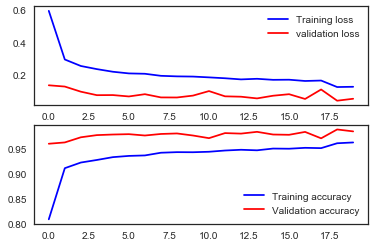

In [54]:
# Build the model
model9 = Sequential()

model9.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='linear', input_shape = (28,28,1)))
model9.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='linear'))
model9.add(MaxPool2D(pool_size=(2,2)))
model9.add(Dropout(0.25))


model9.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='linear'))
model9.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='linear'))
model9.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model9.add(Dropout(0.25))


model9.add(Flatten())
model9.add(Dense(256, activation = "linear"))
model9.add(Dropout(0.5))
model9.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model9.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model9.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model9.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

From the evaluation below, we found that accuracy of model1 is the highest one, so activation function choose relu.

By Zhiwei Zhang, is licensed under the MIT License https://opensource.org/licenses/MIT

<h2>Compare loss functions</h2>

A loss function (or objective function, or optimization score function) is one of the two parameters required to compile a model. Loss functions are used to evaluate the distance to the actual results.

#loss function: model10 use mean_squared_error

Epoch 1/20
 - 248s - loss: 0.0241 - acc: 0.8229 - val_loss: 0.0054 - val_acc: 0.9639
Epoch 2/20
 - 257s - loss: 0.0080 - acc: 0.9478 - val_loss: 0.0035 - val_acc: 0.9778
Epoch 3/20
 - 254s - loss: 0.0060 - acc: 0.9614 - val_loss: 0.0027 - val_acc: 0.9827
Epoch 4/20
 - 257s - loss: 0.0049 - acc: 0.9679 - val_loss: 0.0018 - val_acc: 0.9888
Epoch 5/20
 - 253s - loss: 0.0044 - acc: 0.9722 - val_loss: 0.0017 - val_acc: 0.9892
Epoch 6/20
 - 228s - loss: 0.0040 - acc: 0.9742 - val_loss: 0.0017 - val_acc: 0.9895
Epoch 7/20
 - 214s - loss: 0.0038 - acc: 0.9764 - val_loss: 0.0021 - val_acc: 0.9878
Epoch 8/20
 - 213s - loss: 0.0037 - acc: 0.9765 - val_loss: 0.0014 - val_acc: 0.9916
Epoch 9/20
 - 213s - loss: 0.0034 - acc: 0.9785 - val_loss: 0.0017 - val_acc: 0.9895
Epoch 10/20
 - 213s - loss: 0.0032 - acc: 0.9798 - val_loss: 0.0014 - val_acc: 0.9915
Epoch 11/20
 - 212s - loss: 0.0031 - acc: 0.9813 - val_loss: 0.0014 - val_acc: 0.9911
Epoch 12/20
 - 212s - loss: 0.0031 - acc: 0.9810 - val_loss: 0.

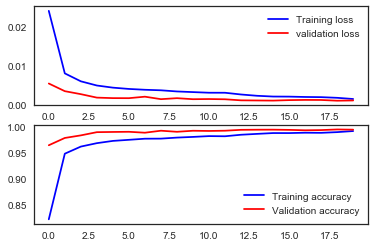

In [55]:
# Build the model
model10 = Sequential()

model10.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model10.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model10.add(MaxPool2D(pool_size=(2,2)))
model10.add(Dropout(0.25))


model10.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model10.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model10.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model10.add(Dropout(0.25))


model10.add(Flatten())
model10.add(Dense(256, activation = "relu"))
model10.add(Dropout(0.5))
model10.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model10.compile(optimizer = optimizer , loss = "mean_squared_error", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model10.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model10.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model11 use mean_absolute_error

Epoch 1/20
 - 248s - loss: 0.0883 - acc: 0.5617 - val_loss: 0.0341 - val_acc: 0.8320
Epoch 2/20
 - 259s - loss: 0.0282 - acc: 0.8602 - val_loss: 0.0079 - val_acc: 0.9605
Epoch 3/20
 - 245s - loss: 0.0184 - acc: 0.9085 - val_loss: 0.0072 - val_acc: 0.9641
Epoch 4/20
 - 242s - loss: 0.0160 - acc: 0.9202 - val_loss: 0.0084 - val_acc: 0.9579
Epoch 5/20
 - 241s - loss: 0.0155 - acc: 0.9226 - val_loss: 0.0071 - val_acc: 0.9648
Epoch 6/20
 - 237s - loss: 0.0145 - acc: 0.9281 - val_loss: 0.0069 - val_acc: 0.9658
Epoch 7/20
 - 231s - loss: 0.0138 - acc: 0.9314 - val_loss: 0.0074 - val_acc: 0.9631
Epoch 8/20
 - 238s - loss: 0.0137 - acc: 0.9315 - val_loss: 0.0067 - val_acc: 0.9661
Epoch 9/20
 - 252s - loss: 0.0132 - acc: 0.9341 - val_loss: 0.0053 - val_acc: 0.9735
Epoch 10/20
 - 289s - loss: 0.0123 - acc: 0.9385 - val_loss: 0.0055 - val_acc: 0.9724
Epoch 11/20
 - 239s - loss: 0.0131 - acc: 0.9346 - val_loss: 0.0050 - val_acc: 0.9752
Epoch 12/20
 - 248s - loss: 0.0126 - acc: 0.9370 - val_loss: 0.

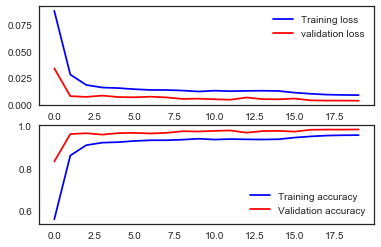

In [56]:
# Build the model
model11 = Sequential()

model11.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model11.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model11.add(MaxPool2D(pool_size=(2,2)))
model11.add(Dropout(0.25))


model11.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model11.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model11.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model11.add(Dropout(0.25))


model11.add(Flatten())
model11.add(Dense(256, activation = "relu"))
model11.add(Dropout(0.5))
model11.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model11.compile(optimizer = optimizer , loss = "mean_absolute_error", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model11.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model11.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model12 use mean_absolute_percentage_error

Epoch 1/20
 - 256s - loss: 35000018.4583 - acc: 0.6536 - val_loss: 14291414.5412 - val_acc: 0.8578
Epoch 2/20
 - 260s - loss: 12415475.5042 - acc: 0.8768 - val_loss: 3965956.5306 - val_acc: 0.9607
Epoch 3/20
 - 280s - loss: 8272836.8705 - acc: 0.9180 - val_loss: 4277510.4218 - val_acc: 0.9576
Epoch 4/20
 - 270s - loss: 7427488.9105 - acc: 0.9258 - val_loss: 2458582.8875 - val_acc: 0.9753
Epoch 5/20
 - 289s - loss: 6936616.4193 - acc: 0.9308 - val_loss: 3404642.5299 - val_acc: 0.9660
Epoch 6/20
 - 261s - loss: 6912707.6640 - acc: 0.9313 - val_loss: 2438927.4743 - val_acc: 0.9756
Epoch 7/20
 - 247s - loss: 6661664.0191 - acc: 0.9335 - val_loss: 2412095.8964 - val_acc: 0.9760
Epoch 8/20
 - 245s - loss: 6609646.9444 - acc: 0.9341 - val_loss: 2740154.5966 - val_acc: 0.9726
Epoch 9/20
 - 244s - loss: 6361612.1980 - acc: 0.9366 - val_loss: 2295507.9953 - val_acc: 0.9772
Epoch 10/20
 - 242s - loss: 6529879.7862 - acc: 0.9346 - val_loss: 2219327.4700 - val_acc: 0.9778
Epoch 11/20
 - 239s - loss

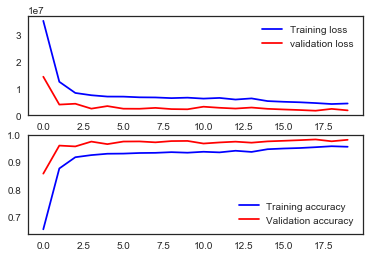

In [57]:
# Build the model
model12 = Sequential()

model12.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model12.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model12.add(MaxPool2D(pool_size=(2,2)))
model12.add(Dropout(0.25))


model12.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model12.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model12.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model12.add(Dropout(0.25))


model12.add(Flatten())
model12.add(Dense(256, activation = "relu"))
model12.add(Dropout(0.5))
model12.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model12.compile(optimizer = optimizer , loss = "mean_absolute_percentage_error", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model12.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model12.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model13 use mean_squared_logarithmic_error

Epoch 1/20
 - 213s - loss: 0.0104 - acc: 0.8477 - val_loss: 0.0021 - val_acc: 0.9729
Epoch 2/20
 - 203s - loss: 0.0038 - acc: 0.9507 - val_loss: 0.0015 - val_acc: 0.9805
Epoch 3/20
 - 203s - loss: 0.0028 - acc: 0.9620 - val_loss: 0.0011 - val_acc: 0.9856
Epoch 4/20
 - 204s - loss: 0.0023 - acc: 0.9693 - val_loss: 0.0013 - val_acc: 0.9835
Epoch 5/20
 - 204s - loss: 0.0021 - acc: 0.9735 - val_loss: 9.8526e-04 - val_acc: 0.9871
Epoch 6/20
 - 205s - loss: 0.0019 - acc: 0.9750 - val_loss: 0.0013 - val_acc: 0.9834
Epoch 7/20
 - 206s - loss: 0.0019 - acc: 0.9759 - val_loss: 7.5970e-04 - val_acc: 0.9902
Epoch 8/20
 - 217s - loss: 0.0017 - acc: 0.9771 - val_loss: 7.5036e-04 - val_acc: 0.9903
Epoch 9/20
 - 236s - loss: 0.0017 - acc: 0.9786 - val_loss: 8.7151e-04 - val_acc: 0.9884
Epoch 10/20
 - 218s - loss: 0.0016 - acc: 0.9796 - val_loss: 8.3893e-04 - val_acc: 0.9898
Epoch 11/20
 - 208s - loss: 0.0015 - acc: 0.9806 - val_loss: 7.0344e-04 - val_acc: 0.9913
Epoch 12/20
 - 207s - loss: 0.0015 - ac

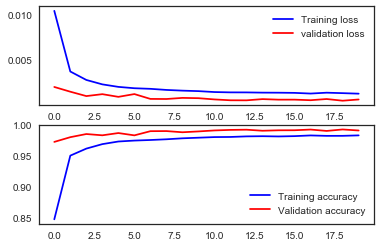

In [65]:
# Build the model
model13 = Sequential()

model13.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model13.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model13.add(MaxPool2D(pool_size=(2,2)))
model13.add(Dropout(0.25))


model13.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model13.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model13.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model13.add(Dropout(0.25))


model13.add(Flatten())
model13.add(Dense(256, activation = "relu"))
model13.add(Dropout(0.5))
model13.add(Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model13.compile(optimizer = optimizer , loss = "mean_squared_logarithmic_error", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model13.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model13.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model14 use squared_hinge

Epoch 1/20
 - 208s - loss: 0.9169 - acc: 0.8105 - val_loss: 0.9030 - val_acc: 0.9651
Epoch 2/20
 - 207s - loss: 0.9052 - acc: 0.9395 - val_loss: 0.9022 - val_acc: 0.9740
Epoch 3/20
 - 207s - loss: 0.9040 - acc: 0.9545 - val_loss: 0.9017 - val_acc: 0.9812
Epoch 4/20
 - 207s - loss: 0.9032 - acc: 0.9619 - val_loss: 0.9015 - val_acc: 0.9818
Epoch 5/20
 - 208s - loss: 0.9028 - acc: 0.9675 - val_loss: 0.9017 - val_acc: 0.9805
Epoch 6/20
 - 206s - loss: 0.9025 - acc: 0.9700 - val_loss: 0.9011 - val_acc: 0.9869
Epoch 7/20
 - 207s - loss: 0.9023 - acc: 0.9729 - val_loss: 0.9011 - val_acc: 0.9870
Epoch 8/20
 - 206s - loss: 0.9022 - acc: 0.9746 - val_loss: 0.9012 - val_acc: 0.9857
Epoch 9/20
 - 206s - loss: 0.9020 - acc: 0.9763 - val_loss: 0.9011 - val_acc: 0.9868
Epoch 10/20
 - 205s - loss: 0.9021 - acc: 0.9752 - val_loss: 0.9010 - val_acc: 0.9888
Epoch 11/20
 - 206s - loss: 0.9019 - acc: 0.9779 - val_loss: 0.9008 - val_acc: 0.9909
Epoch 12/20
 - 206s - loss: 0.9018 - acc: 0.9792 - val_loss: 0.

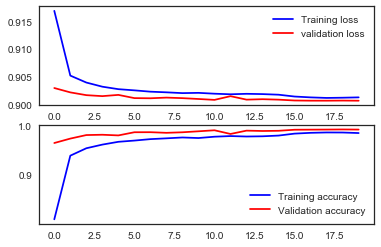

In [58]:
# Build the model
model14 = Sequential()

model14.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model14.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model14.add(MaxPool2D(pool_size=(2,2)))
model14.add(Dropout(0.25))


model14.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model14.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model14.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model14.add(Dropout(0.25))


model14.add(Flatten())
model14.add(Dense(256, activation = "relu"))
model14.add(Dropout(0.5))
model14.add(Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model14.compile(optimizer = optimizer , loss = "squared_hinge", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model14.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model14.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model15 use hinge

Epoch 1/20
 - 208s - loss: 0.9328 - acc: 0.6761 - val_loss: 0.9135 - val_acc: 0.8646
Epoch 2/20
 - 208s - loss: 0.9158 - acc: 0.8426 - val_loss: 0.9038 - val_acc: 0.9621
Epoch 3/20
 - 208s - loss: 0.9086 - acc: 0.9148 - val_loss: 0.9033 - val_acc: 0.9667
Epoch 4/20
 - 208s - loss: 0.9072 - acc: 0.9286 - val_loss: 0.9025 - val_acc: 0.9756
Epoch 5/20
 - 207s - loss: 0.9066 - acc: 0.9341 - val_loss: 0.9024 - val_acc: 0.9762
Epoch 6/20
 - 207s - loss: 0.9065 - acc: 0.9354 - val_loss: 0.9021 - val_acc: 0.9789
Epoch 7/20
 - 207s - loss: 0.9061 - acc: 0.9399 - val_loss: 0.9025 - val_acc: 0.9753
Epoch 8/20
 - 207s - loss: 0.9061 - acc: 0.9386 - val_loss: 0.9025 - val_acc: 0.9752
Epoch 9/20
 - 207s - loss: 0.9061 - acc: 0.9386 - val_loss: 0.9034 - val_acc: 0.9659
Epoch 10/20
 - 207s - loss: 0.9059 - acc: 0.9410 - val_loss: 0.9024 - val_acc: 0.9755

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/20
 - 207s - loss: 0.9048 - acc: 0.9524 - val_loss: 0.9022 

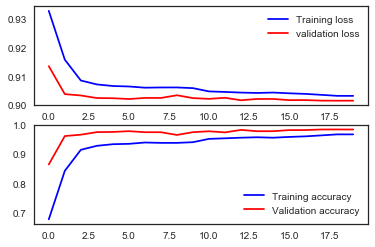

In [59]:
# Build the model
model15 = Sequential()

model15.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model15.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model15.add(MaxPool2D(pool_size=(2,2)))
model15.add(Dropout(0.25))


model15.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model15.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model15.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model15.add(Dropout(0.25))


model15.add(Flatten())
model15.add(Dense(256, activation = "relu"))
model15.add(Dropout(0.5))
model15.add(Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model15.compile(optimizer = optimizer , loss = "hinge", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model15.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model15.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model17 use categorical_hinge

We can see from below evaluation, when using categorical_hinge as our cost function, we got a very low accuracy, so this cost function is definitely not fit our dataset well.

Epoch 1/20
 - 207s - loss: 1.0002 - acc: 0.1015 - val_loss: 1.0001 - val_acc: 0.0943
Epoch 2/20
 - 207s - loss: 1.0001 - acc: 0.0966 - val_loss: 1.0001 - val_acc: 0.1044
Epoch 3/20
 - 206s - loss: 1.0001 - acc: 0.0997 - val_loss: 1.0001 - val_acc: 0.1147
Epoch 4/20
 - 206s - loss: 1.0001 - acc: 0.1033 - val_loss: 1.0001 - val_acc: 0.0993
Epoch 5/20
 - 207s - loss: 1.0001 - acc: 0.1007 - val_loss: 1.0001 - val_acc: 0.0943
Epoch 6/20
 - 207s - loss: 1.0001 - acc: 0.1000 - val_loss: 1.0001 - val_acc: 0.1039
Epoch 7/20
 - 207s - loss: 1.0001 - acc: 0.1003 - val_loss: 1.0001 - val_acc: 0.0994

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/20
 - 207s - loss: 1.0001 - acc: 0.1001 - val_loss: 1.0001 - val_acc: 0.0964
Epoch 9/20
 - 207s - loss: 1.0001 - acc: 0.0971 - val_loss: 1.0001 - val_acc: 0.0899
Epoch 10/20
 - 207s - loss: 1.0001 - acc: 0.0993 - val_loss: 1.0001 - val_acc: 0.1147

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00025000

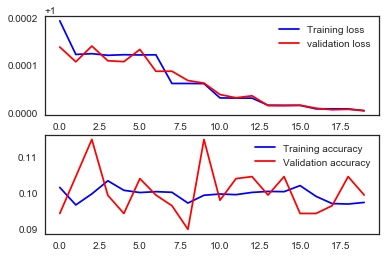

In [60]:
# Build the model
model16 = Sequential()

model16.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model16.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model16.add(MaxPool2D(pool_size=(2,2)))
model16.add(Dropout(0.25))


model16.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model16.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model16.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model16.add(Dropout(0.25))


model16.add(Flatten())
model16.add(Dense(256, activation = "relu"))
model16.add(Dropout(0.5))
model16.add(Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model16.compile(optimizer = optimizer , loss = "categorical_hinge", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model16.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model16.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model17 use logcosh

Epoch 1/20
 - 210s - loss: 0.0106 - acc: 0.8344 - val_loss: 0.0019 - val_acc: 0.9726
Epoch 2/20
 - 209s - loss: 0.0037 - acc: 0.9468 - val_loss: 0.0011 - val_acc: 0.9835
Epoch 3/20
 - 209s - loss: 0.0029 - acc: 0.9587 - val_loss: 0.0011 - val_acc: 0.9839
Epoch 4/20
 - 208s - loss: 0.0024 - acc: 0.9659 - val_loss: 0.0012 - val_acc: 0.9828
Epoch 5/20
 - 209s - loss: 0.0021 - acc: 0.9703 - val_loss: 0.0010 - val_acc: 0.9860
Epoch 6/20
 - 208s - loss: 0.0020 - acc: 0.9730 - val_loss: 8.2143e-04 - val_acc: 0.9883
Epoch 7/20
 - 208s - loss: 0.0018 - acc: 0.9752 - val_loss: 8.0620e-04 - val_acc: 0.9889
Epoch 8/20
 - 208s - loss: 0.0017 - acc: 0.9766 - val_loss: 7.5370e-04 - val_acc: 0.9898
Epoch 9/20
 - 208s - loss: 0.0016 - acc: 0.9773 - val_loss: 6.6639e-04 - val_acc: 0.9909
Epoch 10/20
 - 207s - loss: 0.0016 - acc: 0.9781 - val_loss: 7.1530e-04 - val_acc: 0.9903
Epoch 11/20
 - 208s - loss: 0.0014 - acc: 0.9805 - val_loss: 6.8678e-04 - val_acc: 0.9907
Epoch 12/20
 - 208s - loss: 0.0015 - ac

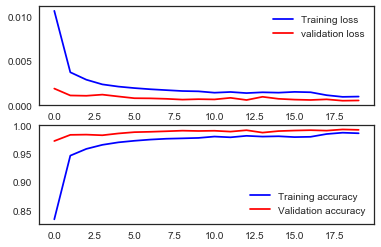

In [61]:
# Build the model
model17 = Sequential()

model17.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model17.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model17.add(MaxPool2D(pool_size=(2,2)))
model17.add(Dropout(0.25))


model17.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model17.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model17.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model17.add(Dropout(0.25))


model17.add(Flatten())
model17.add(Dense(256, activation = "relu"))
model17.add(Dropout(0.5))
model17.add(Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model17.compile(optimizer = optimizer , loss = "logcosh", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model17.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model17.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model18 use sparse_categorical_crossentropy, our predefined one hot encoding does not fit this cost function, so we will use our original label.

In [33]:
train_second = pd.read_csv("train.csv")
test_second = pd.read_csv("test.csv")

In [34]:
Y_train_second = train_second["label"]

# Drop 'label' column
X_train_second = train_second.drop(labels = ["label"],axis = 1)

In [35]:
X_train_second = X_train_second / 255.0
test_second = test_second / 255.0

In [36]:
X_train_second = X_train_second.values.reshape(-1,28,28,1)
test_second = test_second.values.reshape(-1,28,28,1)

In [37]:
# Split the train and the validation set for the fitting
X_train_second, X_val_second, Y_train_second, Y_val_second = train_test_split(X_train_second, Y_train_second, test_size = 0.3, random_state=2)

Epoch 1/20
 - 157s - loss: 0.4935 - acc: 0.8431 - val_loss: 0.0752 - val_acc: 0.9772
Epoch 2/20
 - 138s - loss: 0.1517 - acc: 0.9546 - val_loss: 0.0523 - val_acc: 0.9829
Epoch 3/20
 - 137s - loss: 0.1071 - acc: 0.9685 - val_loss: 0.0588 - val_acc: 0.9822
Epoch 4/20
 - 137s - loss: 0.0896 - acc: 0.9746 - val_loss: 0.0356 - val_acc: 0.9894
Epoch 5/20
 - 137s - loss: 0.0809 - acc: 0.9758 - val_loss: 0.0289 - val_acc: 0.9909
Epoch 6/20
 - 142s - loss: 0.0713 - acc: 0.9796 - val_loss: 0.0468 - val_acc: 0.9865
Epoch 7/20
 - 141s - loss: 0.0670 - acc: 0.9799 - val_loss: 0.0308 - val_acc: 0.9909
Epoch 8/20
 - 144s - loss: 0.0675 - acc: 0.9818 - val_loss: 0.0275 - val_acc: 0.9917
Epoch 9/20
 - 159s - loss: 0.0592 - acc: 0.9836 - val_loss: 0.0530 - val_acc: 0.9885
Epoch 10/20
 - 156s - loss: 0.0618 - acc: 0.9815 - val_loss: 0.0256 - val_acc: 0.9921
Epoch 11/20
 - 151s - loss: 0.0563 - acc: 0.9839 - val_loss: 0.0250 - val_acc: 0.9924
Epoch 12/20
 - 153s - loss: 0.0589 - acc: 0.9835 - val_loss: 0.

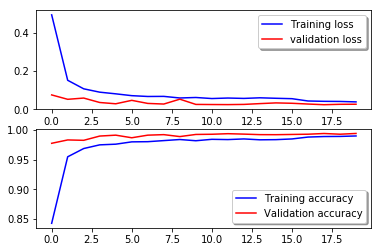

In [38]:
# Build the model
model18 = Sequential()

model18.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model18.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model18.add(MaxPool2D(pool_size=(2,2)))
model18.add(Dropout(0.25))


model18.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model18.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model18.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model18.add(Dropout(0.25))


model18.add(Flatten())
model18.add(Dense(256, activation = "relu"))
model18.add(Dropout(0.5))
model18.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model18.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model18.fit_generator(datagen.flow(X_train_second,Y_train_second, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val_second,Y_val_second),
                              verbose = 2, steps_per_epoch=X_train_second.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model18.evaluate(X_val_second,Y_val_second, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model19 use binary_crossentropy

Epoch 1/20
 - 209s - loss: 0.0769 - acc: 0.9726 - val_loss: 0.0122 - val_acc: 0.9957
Epoch 2/20
 - 208s - loss: 0.0260 - acc: 0.9914 - val_loss: 0.0134 - val_acc: 0.9959
Epoch 3/20
 - 208s - loss: 0.0194 - acc: 0.9938 - val_loss: 0.0090 - val_acc: 0.9969
Epoch 4/20
 - 208s - loss: 0.0161 - acc: 0.9948 - val_loss: 0.0077 - val_acc: 0.9976
Epoch 5/20
 - 208s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 6/20
 - 208s - loss: 0.0126 - acc: 0.9960 - val_loss: 0.0058 - val_acc: 0.9983
Epoch 7/20
 - 207s - loss: 0.0122 - acc: 0.9964 - val_loss: 0.0057 - val_acc: 0.9983
Epoch 8/20
 - 208s - loss: 0.0123 - acc: 0.9962 - val_loss: 0.0059 - val_acc: 0.9982
Epoch 9/20
 - 208s - loss: 0.0111 - acc: 0.9967 - val_loss: 0.0065 - val_acc: 0.9983
Epoch 10/20
 - 208s - loss: 0.0105 - acc: 0.9967 - val_loss: 0.0059 - val_acc: 0.9985
Epoch 11/20
 - 208s - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0049 - val_acc: 0.9985
Epoch 12/20
 - 209s - loss: 0.0109 - acc: 0.9967 - val_loss: 0.

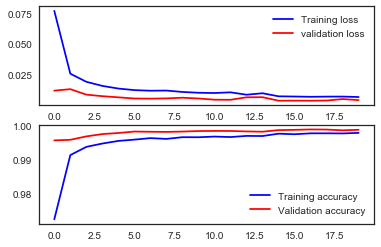

In [62]:
# Build the model
model19 = Sequential()

model19.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model19.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model19.add(MaxPool2D(pool_size=(2,2)))
model19.add(Dropout(0.25))


model19.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model19.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model19.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model19.add(Dropout(0.25))


model19.add(Flatten())
model19.add(Dense(256, activation = "relu"))
model19.add(Dropout(0.5))
model19.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model19.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model19.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model19.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model20 use kullback_leibler_divergence

Epoch 1/20
 - 212s - loss: 0.4954 - acc: 0.8384 - val_loss: 0.0819 - val_acc: 0.9745
Epoch 2/20
 - 210s - loss: 0.1480 - acc: 0.9539 - val_loss: 0.0523 - val_acc: 0.9824
Epoch 3/20
 - 209s - loss: 0.1059 - acc: 0.9679 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 4/20
 - 208s - loss: 0.0895 - acc: 0.9730 - val_loss: 0.0422 - val_acc: 0.9875
Epoch 5/20
 - 208s - loss: 0.0774 - acc: 0.9766 - val_loss: 0.0363 - val_acc: 0.9887
Epoch 6/20
 - 207s - loss: 0.0712 - acc: 0.9781 - val_loss: 0.0313 - val_acc: 0.9917
Epoch 7/20
 - 217s - loss: 0.0685 - acc: 0.9799 - val_loss: 0.0293 - val_acc: 0.9916
Epoch 8/20
 - 230s - loss: 0.0669 - acc: 0.9806 - val_loss: 0.0609 - val_acc: 0.9829
Epoch 9/20
 - 217s - loss: 0.0628 - acc: 0.9817 - val_loss: 0.0264 - val_acc: 0.9927
Epoch 10/20
 - 209s - loss: 0.0606 - acc: 0.9829 - val_loss: 0.0272 - val_acc: 0.9917
Epoch 11/20
 - 209s - loss: 0.0565 - acc: 0.9837 - val_loss: 0.0326 - val_acc: 0.9904
Epoch 12/20
 - 208s - loss: 0.0593 - acc: 0.9836 - val_loss: 0.

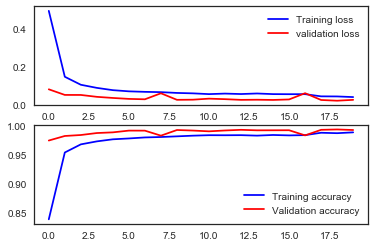

In [63]:
# Build the model
model20 = Sequential()

model20.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model20.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model20.add(MaxPool2D(pool_size=(2,2)))
model20.add(Dropout(0.25))


model20.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model20.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model20.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model20.add(Dropout(0.25))


model20.add(Flatten())
model20.add(Dense(256, activation = "relu"))
model20.add(Dropout(0.5))
model20.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model20.compile(optimizer = optimizer , loss = "kullback_leibler_divergence", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model20.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model20.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model21 use poisson

Epoch 1/20
 - 227s - loss: 0.1490 - acc: 0.8408 - val_loss: 0.1070 - val_acc: 0.9777
Epoch 2/20
 - 219s - loss: 0.1150 - acc: 0.9544 - val_loss: 0.1047 - val_acc: 0.9848
Epoch 3/20
 - 230s - loss: 0.1106 - acc: 0.9683 - val_loss: 0.1049 - val_acc: 0.9837
Epoch 4/20
 - 235s - loss: 0.1091 - acc: 0.9735 - val_loss: 0.1041 - val_acc: 0.9875
Epoch 5/20
 - 205s - loss: 0.1078 - acc: 0.9772 - val_loss: 0.1036 - val_acc: 0.9898
Epoch 6/20
 - 202s - loss: 0.1072 - acc: 0.9797 - val_loss: 0.1036 - val_acc: 0.9895
Epoch 7/20
 - 202s - loss: 0.1069 - acc: 0.9794 - val_loss: 0.1034 - val_acc: 0.9900
Epoch 8/20
 - 204s - loss: 0.1060 - acc: 0.9821 - val_loss: 0.1032 - val_acc: 0.9912
Epoch 9/20
 - 205s - loss: 0.1063 - acc: 0.9823 - val_loss: 0.1033 - val_acc: 0.9904
Epoch 10/20
 - 209s - loss: 0.1061 - acc: 0.9830 - val_loss: 0.1026 - val_acc: 0.9923
Epoch 11/20
 - 211s - loss: 0.1060 - acc: 0.9833 - val_loss: 0.1025 - val_acc: 0.9929
Epoch 12/20
 - 1513s - loss: 0.1061 - acc: 0.9826 - val_loss: 0

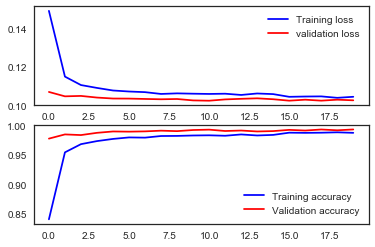

In [68]:
# Build the model
model21 = Sequential()

model21.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model21.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model21.add(MaxPool2D(pool_size=(2,2)))
model21.add(Dropout(0.25))


model21.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model21.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model21.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model21.add(Dropout(0.25))


model21.add(Flatten())
model21.add(Dense(256, activation = "relu"))
model21.add(Dropout(0.5))
model21.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model21.compile(optimizer = optimizer , loss = "poisson", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model21.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model21.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model 19 using binary_crossentropy achieved the highest accuracy, so we choose to use binary_crossentropy as our cost function

By Shujie Fan, is licensed under the MIT License https://opensource.org/licenses/MIT<br>
https://github.com/shujiefan/7390/blob/master/LICENSE

<h2>Compare Optimizer</h2>

An optimizer is one of the two arguments required for compiling a Keras model.

#model23 use SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

Stochastic Gradient Descent (SGD) updates model parameters (theta) in the negative direction of the gradient (g) by taking a subset or a mini-batch of data of size (m).
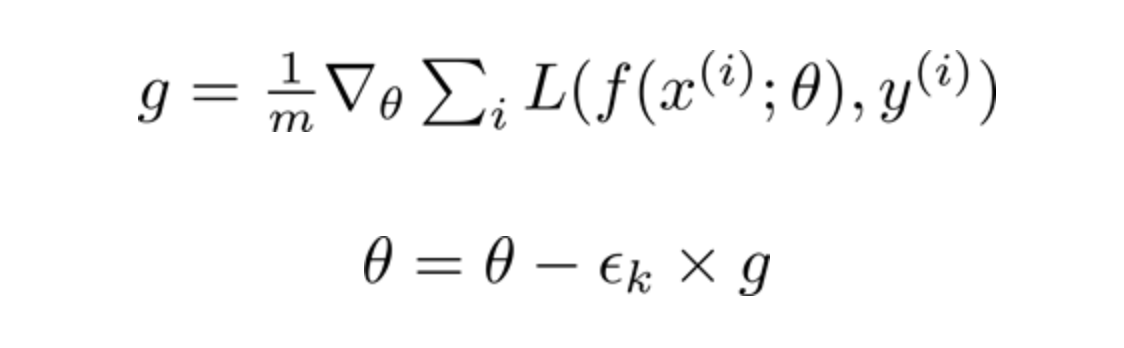
lr: float >= 0. Learning rate.<br>
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.<br>
decay: float >= 0. Learning rate decay over each update.<br>
nesterov: boolean. Whether to apply Nesterov momentum.<br>

Epoch 1/20
 - 217s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000
Epoch 2/20
 - 206s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 3/20
 - 206s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3248 - val_acc: 0.9000
Epoch 4/20
 - 207s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3248 - val_acc: 0.9000
Epoch 5/20
 - 218s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3247 - val_acc: 0.9000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
 - 210s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3247 - val_acc: 0.9000
Epoch 7/20
 - 207s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3246 - val_acc: 0.9000
Epoch 8/20
 - 218s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3246 - val_acc: 0.9000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/20
 - 210s - loss: 0.3249 - acc: 0.9000 - val_loss: 0.3246 - val_acc: 0.9000
Epoch 10/20
 - 212s - loss: 0.3249 - acc: 0.9000 - val_loss: 0.3246 - val

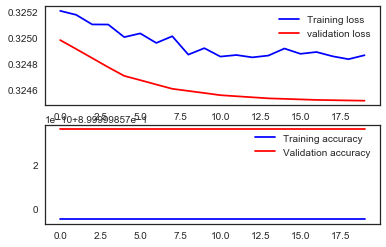

In [71]:
# Build the model
model23 = Sequential()

model23.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model23.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model23.add(MaxPool2D(pool_size=(2,2)))
model23.add(Dropout(0.25))


model23.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model23.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model23.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model23.add(Dropout(0.25))


model23.add(Flatten())
model23.add(Dense(256, activation = "relu"))
model23.add(Dropout(0.5))
model23.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

# Compile the model
model23.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model23.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model23.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model24 use Adagrad(lr=0.001, epsilon=1e-08)

AdaGrad is an adaptive method for setting the learning rate.<br>
lr: float >= 0. Learning rate.<br>
epsilon: float >= 0. If None, defaults to K.epsilon().<br>

Epoch 1/20
 - 219s - loss: 0.1389 - acc: 0.9490 - val_loss: 0.0332 - val_acc: 0.9894
Epoch 2/20
 - 220s - loss: 0.0721 - acc: 0.9744 - val_loss: 0.0252 - val_acc: 0.9917
Epoch 3/20
 - 217s - loss: 0.0595 - acc: 0.9790 - val_loss: 0.0220 - val_acc: 0.9927
Epoch 4/20
 - 234s - loss: 0.0543 - acc: 0.9811 - val_loss: 0.0202 - val_acc: 0.9934
Epoch 5/20
 - 234s - loss: 0.0490 - acc: 0.9831 - val_loss: 0.0192 - val_acc: 0.9935
Epoch 6/20
 - 238s - loss: 0.0455 - acc: 0.9840 - val_loss: 0.0178 - val_acc: 0.9942
Epoch 7/20
 - 220s - loss: 0.0438 - acc: 0.9851 - val_loss: 0.0174 - val_acc: 0.9941
Epoch 8/20
 - 218s - loss: 0.0424 - acc: 0.9854 - val_loss: 0.0168 - val_acc: 0.9943
Epoch 9/20
 - 219s - loss: 0.0404 - acc: 0.9864 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 10/20
 - 238s - loss: 0.0391 - acc: 0.9870 - val_loss: 0.0158 - val_acc: 0.9947
Epoch 11/20
 - 242s - loss: 0.0383 - acc: 0.9869 - val_loss: 0.0152 - val_acc: 0.9948
Epoch 12/20
 - 232s - loss: 0.0366 - acc: 0.9874 - val_loss: 0.

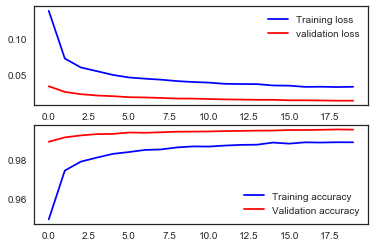

In [72]:
# Build the model
model24 = Sequential()

model24.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model24.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model24.add(MaxPool2D(pool_size=(2,2)))
model24.add(Dropout(0.25))


model24.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model24.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model24.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model24.add(Dropout(0.25))


model24.add(Flatten())
model24.add(Dense(256, activation = "relu"))
model24.add(Dropout(0.5))
model24.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Adagrad(lr=0.001, epsilon=1e-08)

# Compile the model
model24.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model24.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model24.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model25 use Adadelta(lr=0.001, rho=0.9, epsilon=1e-08)

lr: float >= 0. Learning rate. It is recommended to leave it at the default value.<br>
rho: float >= 0.<br>
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().

Epoch 1/20
 - 270s - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 2/20
 - 241s - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 3/20
 - 217s - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000
Epoch 4/20
 - 216s - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000
Epoch 5/20
 - 216s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
 - 217s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 7/20
 - 216s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 8/20
 - 226s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/20
 - 256s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 10/20
 - 245s - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3249 - val

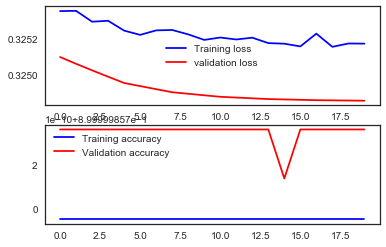

In [73]:
# Build the model
model25 = Sequential()

model25.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model25.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model25.add(MaxPool2D(pool_size=(2,2)))
model25.add(Dropout(0.25))


model25.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model25.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model25.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model25.add(Dropout(0.25))


model25.add(Flatten())
model25.add(Dense(256, activation = "relu"))
model25.add(Dropout(0.5))
model25.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Adadelta(lr=0.001, rho=0.9, epsilon=1e-08)

# Compile the model
model25.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model25.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model25.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model26 use Adam(lr=0.001,epsilon=1e-08)

Adam derives from “adaptive moments”, it can be seen as a variant on the combination of RMSProp and momentum, the update looks like RMSProp except that a smooth version of the gradient is used instead of the raw stochastic gradient, the full Adam update also includes a bias correction mechanism:
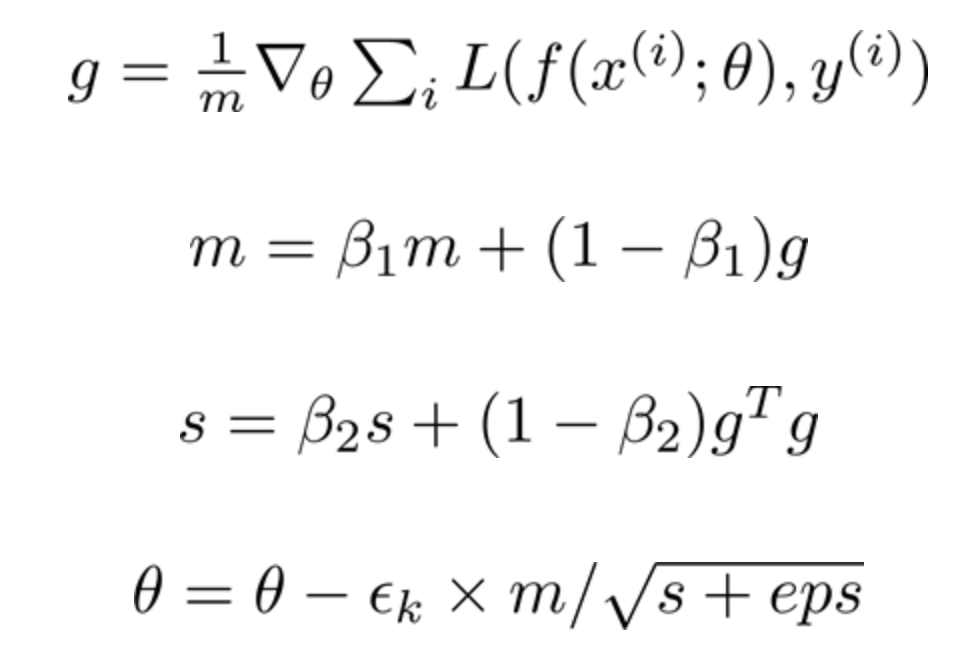
lr: float >= 0. Learning rate.<br>
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().

Epoch 1/20
 - 323s - loss: 0.0798 - acc: 0.9718 - val_loss: 0.0151 - val_acc: 0.9951
Epoch 2/20
 - 307s - loss: 0.0277 - acc: 0.9906 - val_loss: 0.0102 - val_acc: 0.9965
Epoch 3/20
 - 271s - loss: 0.0225 - acc: 0.9926 - val_loss: 0.0084 - val_acc: 0.9972
Epoch 4/20
 - 267s - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0071 - val_acc: 0.9976
Epoch 5/20
 - 267s - loss: 0.0160 - acc: 0.9948 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 6/20
 - 264s - loss: 0.0144 - acc: 0.9955 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 7/20
 - 264s - loss: 0.0128 - acc: 0.9960 - val_loss: 0.0053 - val_acc: 0.9982
Epoch 8/20
 - 265s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0064 - val_acc: 0.9980
Epoch 9/20
 - 292s - loss: 0.0117 - acc: 0.9962 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 10/20
 - 261s - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0053 - val_acc: 0.9985
Epoch 11/20
 - 266s - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0070 - val_acc: 0.9979
Epoch 12/20
 - 267s - loss: 0.0097 - acc: 0.9969 - val_loss: 0.

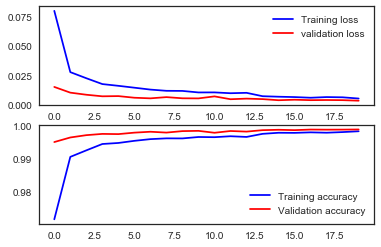

In [74]:
#optimizer = Adam(lr=1e-4)
# Build the model
model26 = Sequential()

model26.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model26.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model26.add(MaxPool2D(pool_size=(2,2)))
model26.add(Dropout(0.25))


model26.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model26.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model26.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model26.add(Dropout(0.25))


model26.add(Flatten())
model26.add(Dense(256, activation = "relu"))
model26.add(Dropout(0.5))
model26.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Adam(lr=0.001,epsilon=1e-08)

# Compile the model
model26.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model26.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model26.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model27 use Adamax(lr=0.001,epsilon=1e-08)

lr: float >= 0. Learning rate.<br>
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().

Epoch 1/20
 - 276s - loss: 0.1154 - acc: 0.9590 - val_loss: 0.0187 - val_acc: 0.9939
Epoch 2/20
 - 272s - loss: 0.0404 - acc: 0.9861 - val_loss: 0.0132 - val_acc: 0.9957
Epoch 3/20
 - 273s - loss: 0.0305 - acc: 0.9901 - val_loss: 0.0109 - val_acc: 0.9963
Epoch 4/20
 - 282s - loss: 0.0247 - acc: 0.9916 - val_loss: 0.0097 - val_acc: 0.9968
Epoch 5/20
 - 273s - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0085 - val_acc: 0.9971
Epoch 6/20
 - 275s - loss: 0.0190 - acc: 0.9937 - val_loss: 0.0074 - val_acc: 0.9976
Epoch 7/20
 - 273s - loss: 0.0177 - acc: 0.9942 - val_loss: 0.0071 - val_acc: 0.9978
Epoch 8/20
 - 277s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 9/20
 - 274s - loss: 0.0151 - acc: 0.9950 - val_loss: 0.0078 - val_acc: 0.9976
Epoch 10/20
 - 274s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 11/20
 - 276s - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 12/20
 - 276s - loss: 0.0125 - acc: 0.9957 - val_loss: 0.

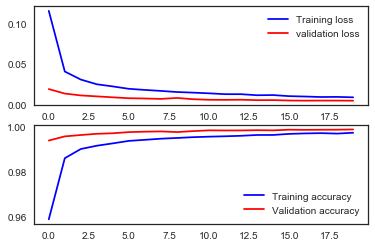

In [75]:
# Build the model
model27 = Sequential()

model27.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model27.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model27.add(MaxPool2D(pool_size=(2,2)))
model27.add(Dropout(0.25))


model27.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model27.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model27.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model27.add(Dropout(0.25))


model27.add(Flatten())
model27.add(Dense(256, activation = "relu"))
model27.add(Dropout(0.5))
model27.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Adamax(lr=0.001,epsilon=1e-08)

# Compile the model
model27.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model27.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model27.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model28 use Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

Nadam (Nesterov Adam optimizer). Much like Adam is essentially RMSprop with momentum, Nadam is Adam RMSprop with Nesterov momentum.<br>
lr: float >= 0. Learning rate.<br>
beta_1/beta_2: floats, 0 < beta < 1. Generally close to 1.<br>
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().

Epoch 1/20
 - 270s - loss: 0.0745 - acc: 0.9739 - val_loss: 0.0117 - val_acc: 0.9964
Epoch 2/20
 - 268s - loss: 0.0255 - acc: 0.9915 - val_loss: 0.0087 - val_acc: 0.9972
Epoch 3/20
 - 267s - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0077 - val_acc: 0.9974
Epoch 4/20
 - 267s - loss: 0.0159 - acc: 0.9946 - val_loss: 0.0079 - val_acc: 0.9974
Epoch 5/20
 - 267s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0064 - val_acc: 0.9978
Epoch 6/20
 - 266s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 7/20
 - 266s - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0061 - val_acc: 0.9980
Epoch 8/20
 - 266s - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 9/20
 - 266s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 10/20
 - 266s - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0041 - val_acc: 0.9986
Epoch 11/20
 - 237s - loss: 0.0100 - acc: 0.9966 - val_loss: 0.0044 - val_acc: 0.9985
Epoch 12/20
 - 211s - loss: 0.0091 - acc: 0.9970 - val_loss: 0.

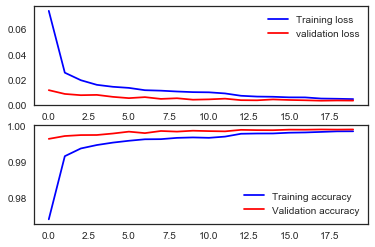

In [76]:
# Build the model
model28 = Sequential()

model28.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model28.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model28.add(MaxPool2D(pool_size=(2,2)))
model28.add(Dropout(0.25))


model28.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model28.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model28.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model28.add(Dropout(0.25))


model28.add(Flatten())
model28.add(Dense(256, activation = "relu"))
model28.add(Dropout(0.5))
model28.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model28.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model28.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model28.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model29 use Nadam(lr=0.002, epsilon=1e-08, schedule_decay=0.004)

Epoch 1/20
 - 243s - loss: 0.0725 - acc: 0.9746 - val_loss: 0.0126 - val_acc: 0.9958
Epoch 2/20
 - 223s - loss: 0.0239 - acc: 0.9921 - val_loss: 0.0086 - val_acc: 0.9971
Epoch 3/20
 - 213s - loss: 0.0181 - acc: 0.9941 - val_loss: 0.0071 - val_acc: 0.9977
Epoch 4/20
 - 227s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 5/20
 - 233s - loss: 0.0134 - acc: 0.9956 - val_loss: 0.0055 - val_acc: 0.9982
Epoch 6/20
 - 212s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 7/20
 - 226s - loss: 0.0112 - acc: 0.9963 - val_loss: 0.0060 - val_acc: 0.9982
Epoch 8/20
 - 215s - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0052 - val_acc: 0.9984
Epoch 9/20
 - 213s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 10/20
 - 215s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0046 - val_acc: 0.9987
Epoch 11/20
 - 219s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0053 - val_acc: 0.9985
Epoch 12/20
 - 218s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.

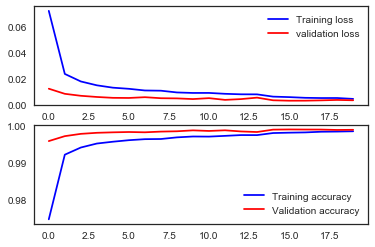

In [77]:
# Build the model
model29 = Sequential()

model29.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model29.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model29.add(MaxPool2D(pool_size=(2,2)))
model29.add(Dropout(0.25))


model29.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model29.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model29.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model29.add(Dropout(0.25))


model29.add(Flatten())
model29.add(Dense(256, activation = "relu"))
model29.add(Dropout(0.5))
model29.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.002, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model29.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

import time 
t1=time.time()
history = model29.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model29.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model30 use Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.0)

Epoch 1/20
 - 250s - loss: 0.0753 - acc: 0.9735 - val_loss: 0.0129 - val_acc: 0.9957
Epoch 2/20
 - 252s - loss: 0.0258 - acc: 0.9916 - val_loss: 0.0106 - val_acc: 0.9963
Epoch 3/20
 - 269s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0090 - val_acc: 0.9967
Epoch 4/20
 - 275s - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0061 - val_acc: 0.9981
Epoch 5/20
 - 281s - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0069 - val_acc: 0.9977
Epoch 6/20
 - 301s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 7/20
 - 300s - loss: 0.0127 - acc: 0.9959 - val_loss: 0.0058 - val_acc: 0.9981
Epoch 8/20
 - 278s - loss: 0.0110 - acc: 0.9965 - val_loss: 0.0052 - val_acc: 0.9984
Epoch 9/20
 - 256s - loss: 0.0106 - acc: 0.9965 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 10/20
 - 248s - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0043 - val_acc: 0.9985
Epoch 11/20
 - 242s - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0047 - val_acc: 0.9985
Epoch 12/20
 - 238s - loss: 0.0090 - acc: 0.9971 - val_loss: 0.

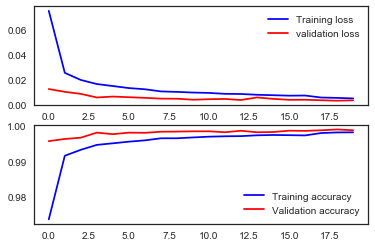

In [78]:
# Build the model
model30 = Sequential()

model30.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model30.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model30.add(MaxPool2D(pool_size=(2,2)))
model30.add(Dropout(0.25))


model30.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model30.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model30.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model30.add(Dropout(0.25))


model30.add(Flatten())
model30.add(Dense(256, activation = "relu"))
model30.add(Dropout(0.5))
model30.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.0)

# Compile the model
model30.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

import time 
t1=time.time()
history = model30.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model30.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

From comparing, we found out optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004) achieves the best result, so we choose this as our optimizer

<h2>Compare Initializer</h2>

Initializations define the way to set the initial random weights of Keras layers.

By Zhiwei Zhang, is licensed under the MIT License https://opensource.org/licenses/MIT

#model31 use uniform

Epoch 1/20
 - 231s - loss: 0.0773 - acc: 0.9725 - val_loss: 0.0126 - val_acc: 0.9954
Epoch 2/20
 - 220s - loss: 0.0265 - acc: 0.9908 - val_loss: 0.0092 - val_acc: 0.9968
Epoch 3/20
 - 215s - loss: 0.0196 - acc: 0.9934 - val_loss: 0.0072 - val_acc: 0.9976
Epoch 4/20
 - 216s - loss: 0.0163 - acc: 0.9946 - val_loss: 0.0066 - val_acc: 0.9978
Epoch 5/20
 - 215s - loss: 0.0150 - acc: 0.9952 - val_loss: 0.0062 - val_acc: 0.9981
Epoch 6/20
 - 214s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0073 - val_acc: 0.9978
Epoch 7/20
 - 215s - loss: 0.0128 - acc: 0.9957 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 8/20
 - 230s - loss: 0.0110 - acc: 0.9966 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 9/20
 - 217s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0046 - val_acc: 0.9985
Epoch 10/20
 - 215s - loss: 0.0100 - acc: 0.9968 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 11/20
 - 220s - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0045 - val_acc: 0.9986
Epoch 12/20
 - 216s - loss: 0.0091 - acc: 0.9972 - val_loss: 0.

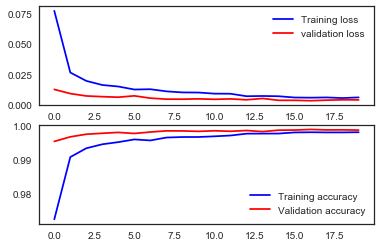

In [81]:
# Build the model
model31 = Sequential()

model31.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='uniform'))
model31.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='uniform'))
model31.add(MaxPool2D(pool_size=(2,2)))
model31.add(Dropout(0.25))


model31.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model31.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model31.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model31.add(Dropout(0.25))


model31.add(Flatten())
model31.add(Dense(256, activation = "relu"))
model31.add(Dropout(0.5))
model31.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model31.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model31.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model31.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model32 use uniform

Epoch 1/20
 - 265s - loss: 0.0803 - acc: 0.9720 - val_loss: 0.0270 - val_acc: 0.9910
Epoch 2/20
 - 262s - loss: 0.0277 - acc: 0.9906 - val_loss: 0.0096 - val_acc: 0.9968
Epoch 3/20
 - 261s - loss: 0.0202 - acc: 0.9935 - val_loss: 0.0080 - val_acc: 0.9972
Epoch 4/20
 - 284s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0079 - val_acc: 0.9974
Epoch 5/20
 - 318s - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0055 - val_acc: 0.9982
Epoch 6/20
 - 333s - loss: 0.0138 - acc: 0.9956 - val_loss: 0.0063 - val_acc: 0.9977
Epoch 7/20
 - 301s - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0058 - val_acc: 0.9981
Epoch 8/20
 - 270s - loss: 0.0112 - acc: 0.9962 - val_loss: 0.0051 - val_acc: 0.9983
Epoch 9/20
 - 266s - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0053 - val_acc: 0.9985
Epoch 10/20
 - 273s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0050 - val_acc: 0.9985
Epoch 11/20
 - 260s - loss: 0.0096 - acc: 0.9969 - val_loss: 0.0042 - val_acc: 0.9984
Epoch 12/20
 - 255s - loss: 0.0097 - acc: 0.9969 - val_loss: 0.

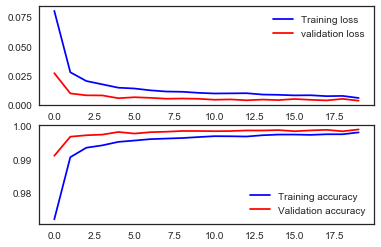

In [82]:
# Build the model
model32 = Sequential()

model32.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='uniform'))
model32.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='uniform'))
model32.add(MaxPool2D(pool_size=(2,2)))
model32.add(Dropout(0.25))


model32.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='uniform'))
model32.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='uniform'))
model32.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model32.add(Dropout(0.25))


model32.add(Flatten())
model32.add(Dense(256, activation = "relu"))
model32.add(Dropout(0.5))
model32.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model32.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model32.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model32.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model33 use lecun_uniform

LeCun uniform initializer.<br>
It draws samples from a uniform distribution within [-limit, limit] where limit is sqrt(3 / fan_in) where  fan_in is the number of input units in the weight tensor.

Epoch 1/20
 - 235s - loss: 0.0706 - acc: 0.9755 - val_loss: 0.0103 - val_acc: 0.9964
Epoch 2/20
 - 228s - loss: 0.0231 - acc: 0.9923 - val_loss: 0.0107 - val_acc: 0.9966
Epoch 3/20
 - 253s - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0075 - val_acc: 0.9977
Epoch 4/20
 - 274s - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 5/20
 - 284s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0061 - val_acc: 0.9980
Epoch 6/20
 - 290s - loss: 0.0122 - acc: 0.9962 - val_loss: 0.0057 - val_acc: 0.9982
Epoch 7/20
 - 308s - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0047 - val_acc: 0.9985
Epoch 8/20
 - 286s - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0044 - val_acc: 0.9986
Epoch 9/20
 - 275s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0050 - val_acc: 0.9985
Epoch 10/20
 - 275s - loss: 0.0094 - acc: 0.9971 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 11/20
 - 277s - loss: 0.0090 - acc: 0.9970 - val_loss: 0.0056 - val_acc: 0.9982

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

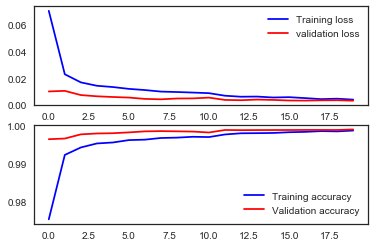

In [83]:
# Build the model
model33 = Sequential()

model33.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='lecun_uniform'))
model33.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='lecun_uniform'))
model33.add(MaxPool2D(pool_size=(2,2)))
model33.add(Dropout(0.25))


model33.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='lecun_uniform'))
model33.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='lecun_uniform'))
model33.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model33.add(Dropout(0.25))


model33.add(Flatten())
model33.add(Dense(256, activation = "relu"))
model33.add(Dropout(0.5))
model33.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model33.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model33.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model33.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model34 use normal

Epoch 1/20
 - 208s - loss: 0.0741 - acc: 0.9740 - val_loss: 0.0149 - val_acc: 0.9949
Epoch 2/20
 - 207s - loss: 0.0250 - acc: 0.9915 - val_loss: 0.0087 - val_acc: 0.9970
Epoch 3/20
 - 206s - loss: 0.0178 - acc: 0.9943 - val_loss: 0.0071 - val_acc: 0.9976
Epoch 4/20
 - 207s - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0057 - val_acc: 0.9980
Epoch 5/20
 - 207s - loss: 0.0138 - acc: 0.9954 - val_loss: 0.0056 - val_acc: 0.9981
Epoch 6/20
 - 231s - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0049 - val_acc: 0.9983
Epoch 7/20
 - 234s - loss: 0.0111 - acc: 0.9964 - val_loss: 0.0048 - val_acc: 0.9985
Epoch 8/20
 - 236s - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 9/20
 - 247s - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0042 - val_acc: 0.9986
Epoch 10/20
 - 286s - loss: 0.0098 - acc: 0.9967 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 11/20
 - 265s - loss: 0.0093 - acc: 0.9971 - val_loss: 0.0041 - val_acc: 0.9987
Epoch 12/20
 - 309s - loss: 0.0091 - acc: 0.9971 - val_loss: 0.

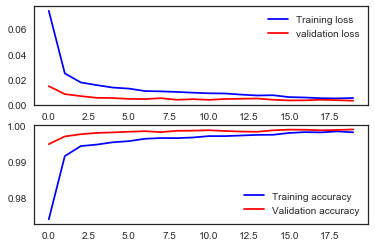

In [84]:
# Build the model
model34 = Sequential()

model34.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='normal'))
model34.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='normal'))
model34.add(MaxPool2D(pool_size=(2,2)))
model34.add(Dropout(0.25))


model34.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='normal'))
model34.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='normal'))
model34.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model34.add(Dropout(0.25))


model34.add(Flatten())
model34.add(Dense(256, activation = "relu"))
model34.add(Dropout(0.5))
model34.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model34.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model34.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model34.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model35 use glorot_normal

Glorot normal initializer, also called Xavier normal initializer.<br>
It draws samples from a truncated normal distribution centered on 0 with  stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.

Epoch 1/20
 - 251s - loss: 0.0767 - acc: 0.9732 - val_loss: 0.0127 - val_acc: 0.9957
Epoch 2/20
 - 224s - loss: 0.0261 - acc: 0.9912 - val_loss: 0.0089 - val_acc: 0.9972
Epoch 3/20
 - 227s - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0076 - val_acc: 0.9976
Epoch 4/20
 - 244s - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0131 - val_acc: 0.9955
Epoch 5/20
 - 246s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0065 - val_acc: 0.9979
Epoch 6/20
 - 246s - loss: 0.0124 - acc: 0.9960 - val_loss: 0.0063 - val_acc: 0.9980
Epoch 7/20
 - 246s - loss: 0.0118 - acc: 0.9960 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 8/20
 - 240s - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0043 - val_acc: 0.9987
Epoch 9/20
 - 246s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 10/20
 - 232s - loss: 0.0097 - acc: 0.9970 - val_loss: 0.0044 - val_acc: 0.9984
Epoch 11/20
 - 215s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0054 - val_acc: 0.9981
Epoch 12/20
 - 214s - loss: 0.0087 - acc: 0.9971 - val_loss: 0.

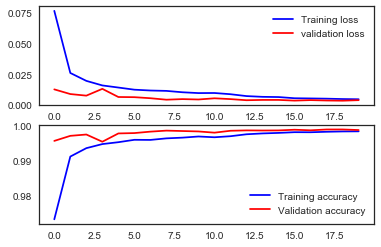

In [85]:
# Build the model
model35 = Sequential()

model35.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_normal'))
model35.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_normal'))
model35.add(MaxPool2D(pool_size=(2,2)))
model35.add(Dropout(0.25))


model35.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_normal'))
model35.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_normal'))
model35.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model35.add(Dropout(0.25))


model35.add(Flatten())
model35.add(Dense(256, activation = "relu"))
model35.add(Dropout(0.5))
model35.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model35.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model35.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model35.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model36 use glorot_uniform

Glorot uniform initializer, also called Xavier uniform initializer.<br>
It draws samples from a uniform distribution within [-limit, limit] where limit is  sqrt(6 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and  fan_out is the number of output units in the weight tensor.

model36 used to be our best model, helped us to gain the highest accuracy of 0.998992, but unfortunately, we didn't get the output to csv file at that time. Now we train this model again and get the output to csv file, the accuracy became lower.

Epoch 1/20
 - 156s - loss: 0.0752 - acc: 0.9732 - val_loss: 0.0144 - val_acc: 0.9952
Epoch 2/20
 - 148s - loss: 0.0260 - acc: 0.9913 - val_loss: 0.0089 - val_acc: 0.9968
Epoch 3/20
 - 149s - loss: 0.0190 - acc: 0.9936 - val_loss: 0.0078 - val_acc: 0.9974
Epoch 4/20
 - 154s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.0065 - val_acc: 0.9979
Epoch 5/20
 - 155s - loss: 0.0145 - acc: 0.9951 - val_loss: 0.0060 - val_acc: 0.9981
Epoch 6/20
 - 156s - loss: 0.0131 - acc: 0.9957 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 7/20
 - 146s - loss: 0.0119 - acc: 0.9960 - val_loss: 0.0056 - val_acc: 0.9981
Epoch 8/20
 - 151s - loss: 0.0107 - acc: 0.9963 - val_loss: 0.0050 - val_acc: 0.9985
Epoch 9/20
 - 160s - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0044 - val_acc: 0.9986
Epoch 10/20
 - 160s - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0043 - val_acc: 0.9985
Epoch 11/20
 - 164s - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0043 - val_acc: 0.9987
Epoch 12/20
 - 155s - loss: 0.0090 - acc: 0.9971 - val_loss: 0.

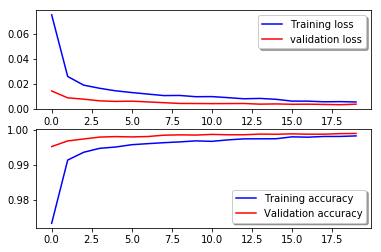

In [28]:
# Build the model
model36 = Sequential()

model36.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model36.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model36.add(MaxPool2D(pool_size=(2,2)))
model36.add(Dropout(0.25))


model36.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model36.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model36.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model36.add(Dropout(0.25))


model36.add(Flatten())
model36.add(Dense(256, activation = "relu"))
model36.add(Dropout(0.5))
model36.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model36.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86


t1=time.time()
history = model36.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model36.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

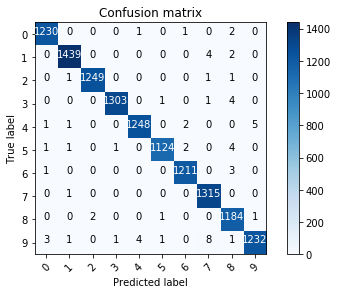

In [30]:
# Look at confusion matrix 
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model36.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [31]:
# predict results
results = model36.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [32]:
# Get the predict result to csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("predict_result.csv",index=False)

#model37 use he_normal

He normal initializer.<br>
It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where  fan_in is the number of input units in the weight tensor.

Epoch 1/20
 - 218s - loss: 0.0709 - acc: 0.9751 - val_loss: 0.0112 - val_acc: 0.9962
Epoch 2/20
 - 219s - loss: 0.0238 - acc: 0.9920 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 3/20
 - 219s - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0066 - val_acc: 0.9978
Epoch 4/20
 - 219s - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0062 - val_acc: 0.9979
Epoch 5/20
 - 219s - loss: 0.0131 - acc: 0.9958 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 6/20
 - 218s - loss: 0.0118 - acc: 0.9961 - val_loss: 0.0049 - val_acc: 0.9983
Epoch 7/20
 - 219s - loss: 0.0107 - acc: 0.9964 - val_loss: 0.0044 - val_acc: 0.9988
Epoch 8/20
 - 219s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0049 - val_acc: 0.9984
Epoch 9/20
 - 219s - loss: 0.0104 - acc: 0.9967 - val_loss: 0.0038 - val_acc: 0.9987
Epoch 10/20
 - 221s - loss: 0.0090 - acc: 0.9969 - val_loss: 0.0041 - val_acc: 0.9986
Epoch 11/20
 - 219s - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0049 - val_acc: 0.9985

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

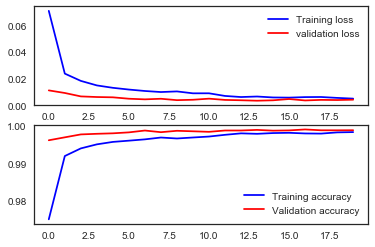

In [87]:
# Build the model
model37 = Sequential()

model37.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='he_normal'))
model37.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_normal'))
model37.add(MaxPool2D(pool_size=(2,2)))
model37.add(Dropout(0.25))


model37.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_normal'))
model37.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_normal'))
model37.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model37.add(Dropout(0.25))


model37.add(Flatten())
model37.add(Dense(256, activation = "relu"))
model37.add(Dropout(0.5))
model37.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model37.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model37.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model37.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model38 use he_uniform

He uniform variance scaling initializer.<br>
It draws samples from a uniform distribution within [-limit, limit] where limit is sqrt(6 / fan_in) where  fan_in is the number of input units in the weight tensor.

Epoch 1/20
 - 219s - loss: 0.0756 - acc: 0.9731 - val_loss: 0.0115 - val_acc: 0.9962
Epoch 2/20
 - 218s - loss: 0.0244 - acc: 0.9918 - val_loss: 0.0074 - val_acc: 0.9975
Epoch 3/20
 - 219s - loss: 0.0178 - acc: 0.9942 - val_loss: 0.0085 - val_acc: 0.9972
Epoch 4/20
 - 220s - loss: 0.0153 - acc: 0.9950 - val_loss: 0.0061 - val_acc: 0.9980
Epoch 5/20
 - 220s - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0054 - val_acc: 0.9981
Epoch 6/20
 - 220s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0060 - val_acc: 0.9981
Epoch 7/20
 - 222s - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0066 - val_acc: 0.9978
Epoch 8/20
 - 221s - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 9/20
 - 220s - loss: 0.0100 - acc: 0.9966 - val_loss: 0.0067 - val_acc: 0.9982
Epoch 10/20
 - 221s - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0044 - val_acc: 0.9985
Epoch 11/20
 - 220s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0050 - val_acc: 0.9985
Epoch 12/20
 - 222s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.

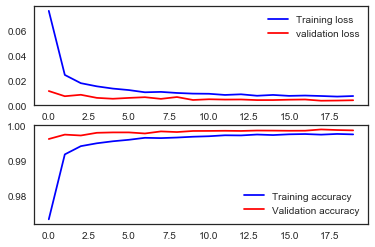

In [88]:
# Build the model
model38 = Sequential()

model38.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='he_uniform'))
model38.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_uniform'))
model38.add(MaxPool2D(pool_size=(2,2)))
model38.add(Dropout(0.25))


model38.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_uniform'))
model38.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='he_uniform'))
model38.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model38.add(Dropout(0.25))


model38.add(Flatten())
model38.add(Dense(256, activation = "relu"))
model38.add(Dropout(0.5))
model38.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model38.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model38.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model38.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

From evaluation above, model36 used to get the highest accuracy, but now model33 achieves the highest accuracy by using lecun_uniform for model initializer. But because our following work is done before the second training of model36, so the following work still choosed model36's glorot_uniform as our initializer.

#model39 add initializer to the Dense layer, compared to model36, the accuracy is the same as the first time's training result, but slightly higher than the second time.

Epoch 1/20
 - 322s - loss: 0.0757 - acc: 0.9736 - val_loss: 0.0149 - val_acc: 0.9951
Epoch 2/20
 - 328s - loss: 0.0251 - acc: 0.9914 - val_loss: 0.0089 - val_acc: 0.9971
Epoch 3/20
 - 318s - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0076 - val_acc: 0.9974
Epoch 4/20
 - 329s - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0061 - val_acc: 0.9980
Epoch 5/20
 - 321s - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 6/20
 - 294s - loss: 0.0125 - acc: 0.9959 - val_loss: 0.0052 - val_acc: 0.9981
Epoch 7/20
 - 287s - loss: 0.0112 - acc: 0.9965 - val_loss: 0.0054 - val_acc: 0.9981
Epoch 8/20
 - 283s - loss: 0.0108 - acc: 0.9964 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 9/20
 - 282s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 10/20
 - 313s - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0045 - val_acc: 0.9985
Epoch 11/20
 - 299s - loss: 0.0097 - acc: 0.9969 - val_loss: 0.0036 - val_acc: 0.9987
Epoch 12/20
 - 318s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.

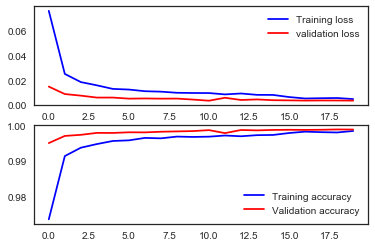

In [89]:
# Build the model
model39 = Sequential()

model39.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model39.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model39.add(MaxPool2D(pool_size=(2,2)))
model39.add(Dropout(0.25))


model39.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model39.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model39.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model39.add(Dropout(0.25))


model39.add(Flatten())
model39.add(Dense(256, kernel_initializer='glorot_uniform', activation = "relu"))
model39.add(Dropout(0.5))
model39.add(Dense(10, kernel_initializer='glorot_uniform', activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model39.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model39.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model36.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

<h2>Compare kernel_size</h2>

kernel_size: An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

#model40 change kernel_size from (5,5) to (3,3), the accuracy is slightly lower than model36

Epoch 1/20
 - 219s - loss: 0.0780 - acc: 0.9725 - val_loss: 0.0118 - val_acc: 0.9959
Epoch 2/20
 - 212s - loss: 0.0267 - acc: 0.9913 - val_loss: 0.0081 - val_acc: 0.9974
Epoch 3/20
 - 212s - loss: 0.0203 - acc: 0.9931 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 4/20
 - 213s - loss: 0.0175 - acc: 0.9943 - val_loss: 0.0057 - val_acc: 0.9982
Epoch 5/20
 - 201s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0058 - val_acc: 0.9981
Epoch 6/20
 - 207s - loss: 0.0127 - acc: 0.9961 - val_loss: 0.0061 - val_acc: 0.9982
Epoch 7/20
 - 209s - loss: 0.0124 - acc: 0.9960 - val_loss: 0.0053 - val_acc: 0.9982
Epoch 8/20
 - 204s - loss: 0.0115 - acc: 0.9961 - val_loss: 0.0054 - val_acc: 0.9983
Epoch 9/20
 - 201s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0050 - val_acc: 0.9984
Epoch 10/20
 - 175s - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0052 - val_acc: 0.9985
Epoch 11/20
 - 193s - loss: 0.0096 - acc: 0.9968 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 12/20
 - 192s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.

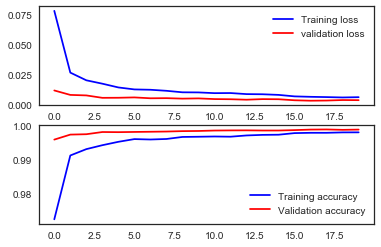

In [90]:
# Build the model
model40 = Sequential()

model40.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model40.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model40.add(MaxPool2D(pool_size=(2,2)))
model40.add(Dropout(0.25))


model40.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model40.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model40.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model40.add(Dropout(0.25))


model40.add(Flatten())
model40.add(Dense(256, activation = "relu"))
model40.add(Dropout(0.5))
model40.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model40.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model40.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model40.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model41 change kernel_size from (5,5) to (8,8), the accuracy is slightly lower than model36, and also lower than model40.

Epoch 1/20
 - 546s - loss: 0.0731 - acc: 0.9745 - val_loss: 0.0133 - val_acc: 0.9956
Epoch 2/20
 - 496s - loss: 0.0232 - acc: 0.9925 - val_loss: 0.0098 - val_acc: 0.9966
Epoch 3/20
 - 492s - loss: 0.0182 - acc: 0.9939 - val_loss: 0.0083 - val_acc: 0.9976
Epoch 4/20
 - 507s - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0075 - val_acc: 0.9977
Epoch 5/20
 - 518s - loss: 0.0133 - acc: 0.9956 - val_loss: 0.0065 - val_acc: 0.9978
Epoch 6/20
 - 496s - loss: 0.0123 - acc: 0.9961 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 7/20
 - 506s - loss: 0.0109 - acc: 0.9964 - val_loss: 0.0062 - val_acc: 0.9979
Epoch 8/20
 - 500s - loss: 0.0102 - acc: 0.9966 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 9/20
 - 497s - loss: 0.0094 - acc: 0.9971 - val_loss: 0.0051 - val_acc: 0.9987
Epoch 10/20
 - 498s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0062 - val_acc: 0.9984
Epoch 11/20
 - 501s - loss: 0.0093 - acc: 0.9971 - val_loss: 0.0047 - val_acc: 0.9985
Epoch 12/20
 - 486s - loss: 0.0087 - acc: 0.9970 - val_loss: 0.

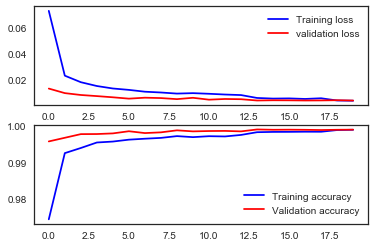

In [92]:
# Build the model
model41 = Sequential()

model41.add(Conv2D(filters = 32, kernel_size = (8,8),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model41.add(Conv2D(filters = 32, kernel_size = (8,8),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model41.add(MaxPool2D(pool_size=(2,2)))
model41.add(Dropout(0.25))


model41.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model41.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model41.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model41.add(Dropout(0.25))


model41.add(Flatten())
model41.add(Dense(256, activation = "relu"))
model41.add(Dropout(0.5))
model41.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model41.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model41.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model41.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

From testing above, kernel_size = (5,5) achieves the highest accuracy.

<h2>Compare filters</h2>

Filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

#model42 change the filter of the first two convolutional layers from 32 to 64, the accuracy is slightly lower than model36

Epoch 1/20
 - 681s - loss: 0.0682 - acc: 0.9763 - val_loss: 0.0100 - val_acc: 0.9966
Epoch 2/20
 - 810s - loss: 0.0228 - acc: 0.9925 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 3/20
 - 771s - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 4/20
 - 820s - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0064 - val_acc: 0.9978
Epoch 5/20
 - 785s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 6/20
 - 710s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0056 - val_acc: 0.9982
Epoch 7/20
 - 704s - loss: 0.0106 - acc: 0.9964 - val_loss: 0.0049 - val_acc: 0.9986
Epoch 8/20
 - 778s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0044 - val_acc: 0.9986
Epoch 9/20
 - 783s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0040 - val_acc: 0.9987
Epoch 10/20
 - 813s - loss: 0.0088 - acc: 0.9971 - val_loss: 0.0045 - val_acc: 0.9987
Epoch 11/20
 - 809s - loss: 0.0087 - acc: 0.9972 - val_loss: 0.0043 - val_acc: 0.9986
Epoch 12/20
 - 727s - loss: 0.0080 - acc: 0.9974 - val_loss: 0.

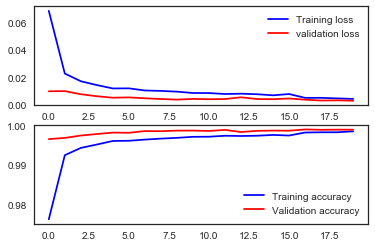

In [94]:
# Build the model
model42 = Sequential()

model42.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model42.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model42.add(MaxPool2D(pool_size=(2,2)))
model42.add(Dropout(0.25))


model42.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model42.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model42.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model42.add(Dropout(0.25))


model42.add(Flatten())
model42.add(Dense(256, activation = "relu"))
model42.add(Dropout(0.5))
model42.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model42.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model42.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model42.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model43 change the filter of the first two convolutional layers from 32 to 16, the accuracy is slightly lower than model36, and also lower than model42.

Epoch 1/20
 - 164s - loss: 0.0810 - acc: 0.9711 - val_loss: 0.0178 - val_acc: 0.9943
Epoch 2/20
 - 169s - loss: 0.0287 - acc: 0.9904 - val_loss: 0.0097 - val_acc: 0.9968
Epoch 3/20
 - 191s - loss: 0.0219 - acc: 0.9929 - val_loss: 0.0074 - val_acc: 0.9974
Epoch 4/20
 - 186s - loss: 0.0179 - acc: 0.9943 - val_loss: 0.0078 - val_acc: 0.9975
Epoch 5/20
 - 195s - loss: 0.0152 - acc: 0.9949 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 6/20
 - 185s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0064 - val_acc: 0.9979
Epoch 7/20
 - 185s - loss: 0.0125 - acc: 0.9959 - val_loss: 0.0050 - val_acc: 0.9984
Epoch 8/20
 - 204s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0050 - val_acc: 0.9983
Epoch 9/20
 - 203s - loss: 0.0118 - acc: 0.9961 - val_loss: 0.0057 - val_acc: 0.9982
Epoch 10/20
 - 191s - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0052 - val_acc: 0.9985
Epoch 11/20
 - 169s - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0053 - val_acc: 0.9982

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

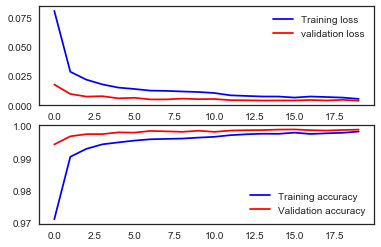

In [95]:
# Build the model
model43 = Sequential()

model43.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model43.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model43.add(MaxPool2D(pool_size=(2,2)))
model43.add(Dropout(0.25))


model43.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model43.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model43.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model43.add(Dropout(0.25))


model43.add(Flatten())
model43.add(Dense(256, activation = "relu"))
model43.add(Dropout(0.5))
model43.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model43.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model43.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model43.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

By Shujie Fan, is licensed under the MIT License https://opensource.org/licenses/MIT<br>
https://github.com/shujiefan/7390/blob/master/LICENSE

<h2>Compare network architecture</h2>
All the comparations are based on model36.

#model44 add BatchNormalization() layer to model36, the accuracy is slightly lower than model36

Epoch 1/20
 - 354s - loss: 0.0867 - acc: 0.9707 - val_loss: 0.0168 - val_acc: 0.9945
Epoch 2/20
 - 362s - loss: 0.0311 - acc: 0.9899 - val_loss: 0.0125 - val_acc: 0.9961
Epoch 3/20
 - 420s - loss: 0.0242 - acc: 0.9924 - val_loss: 0.0114 - val_acc: 0.9963
Epoch 4/20
 - 469s - loss: 0.0204 - acc: 0.9937 - val_loss: 0.0071 - val_acc: 0.9978
Epoch 5/20
 - 457s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0088 - val_acc: 0.9975
Epoch 6/20
 - 464s - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0073 - val_acc: 0.9976
Epoch 7/20
 - 478s - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0073 - val_acc: 0.9978
Epoch 8/20
 - 496s - loss: 0.0150 - acc: 0.9955 - val_loss: 0.0083 - val_acc: 0.9974

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/20
 - 486s - loss: 0.0108 - acc: 0.9967 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 10/20
 - 465s - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 11/20
 - 456s - loss: 0.0097 - acc: 0.9970 - val_loss: 0.0056 

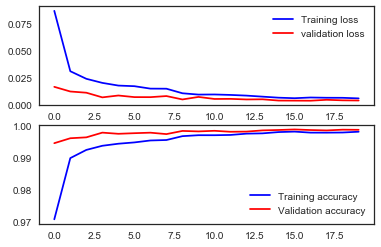

In [97]:
# Build the model
from keras.layers import BatchNormalization
model44 = Sequential()

model44.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model44.add(BatchNormalization())
model44.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model44.add(BatchNormalization())
model44.add(MaxPool2D(pool_size=(2,2)))
model44.add(Dropout(0.25))


model44.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model44.add(BatchNormalization())
model44.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model44.add(BatchNormalization())
model44.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model44.add(Dropout(0.25))


model44.add(Flatten())
model44.add(Dense(256, activation = "relu"))
model44.add(Dropout(0.5))
model44.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model44.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model44.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model44.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model45 add strides to the pooling layer, the accuracy is slightly lower than model36

Epoch 1/20
 - 271s - loss: 0.0936 - acc: 0.9685 - val_loss: 0.0316 - val_acc: 0.9900
Epoch 2/20
 - 272s - loss: 0.0319 - acc: 0.9897 - val_loss: 0.0124 - val_acc: 0.9960
Epoch 3/20
 - 267s - loss: 0.0254 - acc: 0.9920 - val_loss: 0.0133 - val_acc: 0.9958
Epoch 4/20
 - 273s - loss: 0.0211 - acc: 0.9934 - val_loss: 0.0097 - val_acc: 0.9971
Epoch 5/20
 - 281s - loss: 0.0182 - acc: 0.9943 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 6/20
 - 283s - loss: 0.0178 - acc: 0.9947 - val_loss: 0.0081 - val_acc: 0.9977
Epoch 7/20
 - 270s - loss: 0.0173 - acc: 0.9944 - val_loss: 0.0074 - val_acc: 0.9979
Epoch 8/20
 - 279s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0172 - val_acc: 0.9952
Epoch 9/20
 - 321s - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0075 - val_acc: 0.9980
Epoch 10/20
 - 297s - loss: 0.0143 - acc: 0.9956 - val_loss: 0.0127 - val_acc: 0.9963
Epoch 11/20
 - 308s - loss: 0.0133 - acc: 0.9959 - val_loss: 0.0070 - val_acc: 0.9982
Epoch 12/20
 - 308s - loss: 0.0122 - acc: 0.9962 - val_loss: 0.

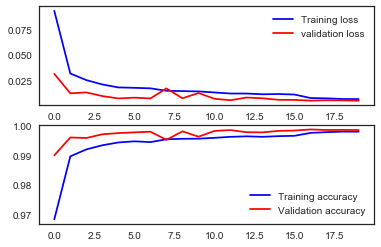

In [98]:
# Build the model
model45 = Sequential()

model45.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))

model45.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))

model45.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model45.add(Dropout(0.25))


model45.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model45.add(BatchNormalization())
model45.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model45.add(BatchNormalization())
model45.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model45.add(Dropout(0.25))


model45.add(Flatten())
model45.add(Dense(256, activation = "relu"))
model45.add(Dropout(0.5))
model45.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model45.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model45.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model45.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model46 change the pooling layer from maxpool to AveragePooling, the accuracy is slightly lower than model36

Epoch 1/20
 - 240s - loss: 0.0818 - acc: 0.9708 - val_loss: 0.0170 - val_acc: 0.9942
Epoch 2/20
 - 253s - loss: 0.0289 - acc: 0.9904 - val_loss: 0.0105 - val_acc: 0.9966
Epoch 3/20
 - 286s - loss: 0.0202 - acc: 0.9932 - val_loss: 0.0076 - val_acc: 0.9975
Epoch 4/20
 - 325s - loss: 0.0171 - acc: 0.9944 - val_loss: 0.0084 - val_acc: 0.9972
Epoch 5/20
 - 267s - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 6/20
 - 248s - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0069 - val_acc: 0.9977
Epoch 7/20
 - 254s - loss: 0.0120 - acc: 0.9962 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 8/20
 - 251s - loss: 0.0111 - acc: 0.9964 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 9/20
 - 255s - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 10/20
 - 249s - loss: 0.0107 - acc: 0.9964 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 11/20
 - 269s - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 12/20
 - 296s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.

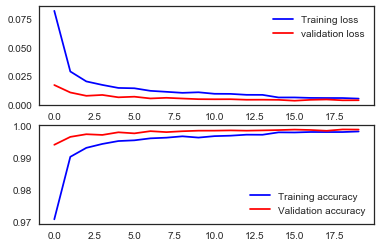

In [101]:
# Build the model
from keras.layers import AveragePooling2D
model46 = Sequential()

model46.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))

model46.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))

model46.add(AveragePooling2D(pool_size=(2,2)))
model46.add(Dropout(0.25))


model46.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model46.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model46.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model46.add(Dropout(0.25))


model46.add(Flatten())
model46.add(Dense(256, activation = "relu"))
model46.add(Dropout(0.5))
model46.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model46.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model46.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model46.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model47 add one convolutional layer, the accuracy is slightly lower than model36

Epoch 1/20
 - 400s - loss: 0.0778 - acc: 0.9728 - val_loss: 0.0156 - val_acc: 0.9953
Epoch 2/20
 - 399s - loss: 0.0253 - acc: 0.9916 - val_loss: 0.0101 - val_acc: 0.9967
Epoch 3/20
 - 362s - loss: 0.0179 - acc: 0.9941 - val_loss: 0.0072 - val_acc: 0.9977
Epoch 4/20
 - 353s - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0061 - val_acc: 0.9980
Epoch 5/20
 - 345s - loss: 0.0138 - acc: 0.9956 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 6/20
 - 341s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0055 - val_acc: 0.9982
Epoch 7/20
 - 343s - loss: 0.0110 - acc: 0.9965 - val_loss: 0.0057 - val_acc: 0.9983
Epoch 8/20
 - 339s - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 9/20
 - 342s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0062 - val_acc: 0.9979
Epoch 10/20
 - 341s - loss: 0.0096 - acc: 0.9968 - val_loss: 0.0042 - val_acc: 0.9987
Epoch 11/20
 - 341s - loss: 0.0089 - acc: 0.9971 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 12/20
 - 342s - loss: 0.0087 - acc: 0.9973 - val_loss: 0.

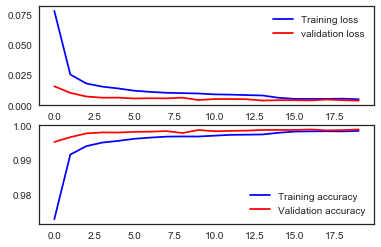

In [104]:
# Build the model
model47 = Sequential()

model47.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model47.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model47.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model47.add(MaxPool2D(pool_size=(2,2)))
model47.add(Dropout(0.25))


model47.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model47.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model47.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model47.add(Dropout(0.25))

model47.add(Flatten())
model47.add(Dense(256, activation = "relu"))
model47.add(Dropout(0.5))
model47.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model47.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model47.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model47.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model48 add two convolutional layers, the accuracy is slightly lower than model36, but slightly higher than model47

Epoch 1/20
 - 388s - loss: 0.0784 - acc: 0.9728 - val_loss: 0.0120 - val_acc: 0.9958
Epoch 2/20
 - 391s - loss: 0.0237 - acc: 0.9923 - val_loss: 0.0088 - val_acc: 0.9969
Epoch 3/20
 - 385s - loss: 0.0168 - acc: 0.9945 - val_loss: 0.0080 - val_acc: 0.9973
Epoch 4/20
 - 385s - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0072 - val_acc: 0.9976
Epoch 5/20
 - 380s - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0053 - val_acc: 0.9981
Epoch 6/20
 - 392s - loss: 0.0108 - acc: 0.9964 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 7/20
 - 409s - loss: 0.0109 - acc: 0.9966 - val_loss: 0.0055 - val_acc: 0.9983
Epoch 8/20
 - 385s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 9/20
 - 374s - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0047 - val_acc: 0.9987
Epoch 10/20
 - 369s - loss: 0.0089 - acc: 0.9972 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 11/20
 - 367s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.0046 - val_acc: 0.9985
Epoch 12/20
 - 366s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.

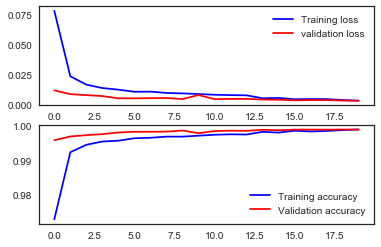

In [105]:
# Build the model
model48 = Sequential()

model48.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model48.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model48.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model48.add(MaxPool2D(pool_size=(2,2)))
model48.add(Dropout(0.25))


model48.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model48.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model48.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model48.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model48.add(Dropout(0.25))

model48.add(Flatten())
model48.add(Dense(256, activation = "relu"))
model48.add(Dropout(0.5))
model48.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model48.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model48.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model48.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model49 delete one convolutional layer, the accuracy is lower than model36

Epoch 1/20
 - 94s - loss: 0.0787 - acc: 0.9722 - val_loss: 0.0165 - val_acc: 0.9943
Epoch 2/20
 - 85s - loss: 0.0282 - acc: 0.9906 - val_loss: 0.0101 - val_acc: 0.9966
Epoch 3/20
 - 86s - loss: 0.0210 - acc: 0.9929 - val_loss: 0.0075 - val_acc: 0.9974
Epoch 4/20
 - 89s - loss: 0.0177 - acc: 0.9941 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 5/20
 - 94s - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0068 - val_acc: 0.9978
Epoch 6/20
 - 92s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 7/20
 - 86s - loss: 0.0126 - acc: 0.9959 - val_loss: 0.0060 - val_acc: 0.9981
Epoch 8/20
 - 84s - loss: 0.0119 - acc: 0.9960 - val_loss: 0.0054 - val_acc: 0.9983
Epoch 9/20
 - 83s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 10/20
 - 83s - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0044 - val_acc: 0.9986
Epoch 11/20
 - 83s - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0049 - val_acc: 0.9985
Epoch 12/20
 - 82s - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0045 - val_a

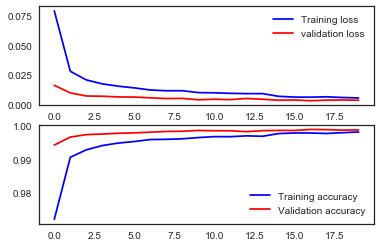

In [113]:
# Build the model
model49 = Sequential()

model49.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model49.add(MaxPool2D(pool_size=(2,2)))
model49.add(Dropout(0.25))


model49.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model49.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model49.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model49.add(Dropout(0.25))

model49.add(Flatten())
model49.add(Dense(256, activation = "relu"))
model49.add(Dropout(0.5))
model49.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model49.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model49.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model49.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model50 delete one convolutional layer, the accuracy is lower than model36

Epoch 1/20
 - 179s - loss: 0.0794 - acc: 0.9718 - val_loss: 0.0149 - val_acc: 0.9949
Epoch 2/20
 - 167s - loss: 0.0300 - acc: 0.9899 - val_loss: 0.0099 - val_acc: 0.9965
Epoch 3/20
 - 170s - loss: 0.0225 - acc: 0.9926 - val_loss: 0.0121 - val_acc: 0.9960
Epoch 4/20
 - 185s - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0070 - val_acc: 0.9974
Epoch 5/20
 - 177s - loss: 0.0164 - acc: 0.9947 - val_loss: 0.0069 - val_acc: 0.9976
Epoch 6/20
 - 181s - loss: 0.0148 - acc: 0.9950 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 7/20
 - 192s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0064 - val_acc: 0.9979
Epoch 8/20
 - 168s - loss: 0.0124 - acc: 0.9959 - val_loss: 0.0069 - val_acc: 0.9977
Epoch 9/20
 - 170s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0051 - val_acc: 0.9983
Epoch 10/20
 - 163s - loss: 0.0115 - acc: 0.9963 - val_loss: 0.0047 - val_acc: 0.9984
Epoch 11/20
 - 165s - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0042 - val_acc: 0.9986
Epoch 12/20
 - 166s - loss: 0.0107 - acc: 0.9963 - val_loss: 0.

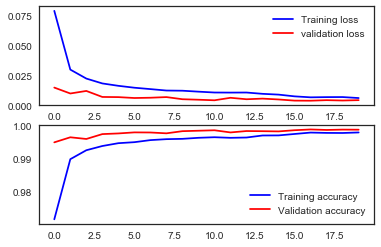

In [115]:
# Build the model
model50 = Sequential()

model50.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model50.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model50.add(MaxPool2D(pool_size=(2,2)))
model50.add(Dropout(0.25))


model50.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model50.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model50.add(Dropout(0.25))

model50.add(Flatten())
model50.add(Dense(256, activation = "relu"))
model50.add(Dropout(0.5))
model50.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model50.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model50.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model50.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model51 delete two convolutional layers, the accuracy is lower than model36, and also lower than model49 and model50

Epoch 1/20
 - 47s - loss: 0.0934 - acc: 0.9665 - val_loss: 0.0168 - val_acc: 0.9939
Epoch 2/20
 - 43s - loss: 0.0364 - acc: 0.9873 - val_loss: 0.0113 - val_acc: 0.9964
Epoch 3/20
 - 44s - loss: 0.0278 - acc: 0.9905 - val_loss: 0.0097 - val_acc: 0.9965
Epoch 4/20
 - 43s - loss: 0.0236 - acc: 0.9920 - val_loss: 0.0085 - val_acc: 0.9970
Epoch 5/20
 - 43s - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0068 - val_acc: 0.9978
Epoch 6/20
 - 44s - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0071 - val_acc: 0.9977
Epoch 7/20
 - 44s - loss: 0.0168 - acc: 0.9944 - val_loss: 0.0062 - val_acc: 0.9979
Epoch 8/20
 - 44s - loss: 0.0157 - acc: 0.9947 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 9/20
 - 44s - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0070 - val_acc: 0.9978
Epoch 10/20
 - 44s - loss: 0.0135 - acc: 0.9955 - val_loss: 0.0065 - val_acc: 0.9976
Epoch 11/20
 - 44s - loss: 0.0137 - acc: 0.9953 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 12/20
 - 44s - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0055 - val_a

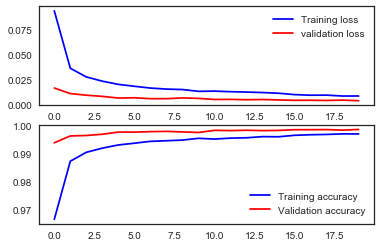

In [116]:
# Build the model
model51 = Sequential()

model51.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model51.add(MaxPool2D(pool_size=(2,2)))
model51.add(Dropout(0.25))


model51.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model51.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model51.add(Dropout(0.25))

model51.add(Flatten())
model51.add(Dense(256, activation = "relu"))
model51.add(Dropout(0.5))
model51.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model51.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model51.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model51.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

By Jing Yang, is licensed under the MIT License https://opensource.org/licenses/MIT<br>

<h2>Compare dropout value</h2>

#model52 change the dropout value to 0, that also means the dropout layer is not functioning, the accuracy is lower than model36 with no doubt.

Epoch 1/20
 - 164s - loss: 0.0615 - acc: 0.9786 - val_loss: 0.0148 - val_acc: 0.9949
Epoch 2/20
 - 162s - loss: 0.0191 - acc: 0.9935 - val_loss: 0.0086 - val_acc: 0.9973
Epoch 3/20
 - 159s - loss: 0.0141 - acc: 0.9952 - val_loss: 0.0070 - val_acc: 0.9978
Epoch 4/20
 - 160s - loss: 0.0112 - acc: 0.9962 - val_loss: 0.0074 - val_acc: 0.9975
Epoch 5/20
 - 160s - loss: 0.0102 - acc: 0.9967 - val_loss: 0.0073 - val_acc: 0.9976
Epoch 6/20
 - 162s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0050 - val_acc: 0.9985
Epoch 7/20
 - 160s - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0040 - val_acc: 0.9986
Epoch 8/20
 - 160s - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 9/20
 - 162s - loss: 0.0068 - acc: 0.9978 - val_loss: 0.0052 - val_acc: 0.9981
Epoch 10/20
 - 159s - loss: 0.0063 - acc: 0.9978 - val_loss: 0.0056 - val_acc: 0.9982
Epoch 11/20
 - 159s - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0058 - val_acc: 0.9982

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

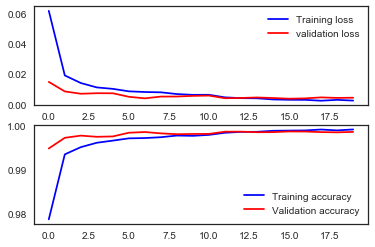

In [117]:
#change dropout
#dropout - 0.25
# Build the model
model52 = Sequential()

model52.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model52.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model52.add(MaxPool2D(pool_size=(2,2)))
model52.add(Dropout(0))


model52.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model52.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model52.add(Dropout(0))

model52.add(Flatten())
model52.add(Dense(256, activation = "relu"))
model52.add(Dropout(0.25))
model52.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model52.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model52.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model52.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model53 change the dropout value to 0.5, will dropout 50% of neurons, the accuracy is lower than model36.

Epoch 1/20
 - 169s - loss: 0.1322 - acc: 0.9522 - val_loss: 0.0223 - val_acc: 0.9928
Epoch 2/20
 - 169s - loss: 0.0599 - acc: 0.9795 - val_loss: 0.0166 - val_acc: 0.9942
Epoch 3/20
 - 171s - loss: 0.0450 - acc: 0.9849 - val_loss: 0.0115 - val_acc: 0.9958
Epoch 4/20
 - 168s - loss: 0.0372 - acc: 0.9876 - val_loss: 0.0105 - val_acc: 0.9963
Epoch 5/20
 - 169s - loss: 0.0328 - acc: 0.9892 - val_loss: 0.0105 - val_acc: 0.9964
Epoch 6/20
 - 169s - loss: 0.0290 - acc: 0.9906 - val_loss: 0.0089 - val_acc: 0.9971
Epoch 7/20
 - 170s - loss: 0.0270 - acc: 0.9913 - val_loss: 0.0094 - val_acc: 0.9970
Epoch 8/20
 - 171s - loss: 0.0259 - acc: 0.9916 - val_loss: 0.0080 - val_acc: 0.9975
Epoch 9/20
 - 169s - loss: 0.0245 - acc: 0.9921 - val_loss: 0.0069 - val_acc: 0.9977
Epoch 10/20
 - 170s - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0068 - val_acc: 0.9978
Epoch 11/20
 - 168s - loss: 0.0226 - acc: 0.9927 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 12/20
 - 166s - loss: 0.0219 - acc: 0.9930 - val_loss: 0.

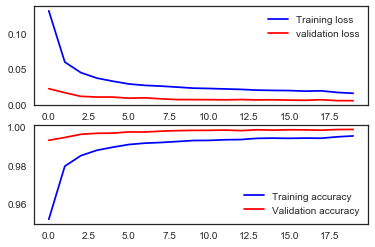

In [118]:
# Build the model
model53 = Sequential()

model53.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model53.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model53.add(MaxPool2D(pool_size=(2,2)))
model53.add(Dropout(0.5))


model53.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model53.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model53.add(Dropout(0.5))

model53.add(Flatten())
model53.add(Dense(256, activation = "relu"))
model53.add(Dropout(0.75))
model53.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model53.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model53.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model53.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model53 change the dropout value to 0.75, will dropout 75% of neurons, the accuracy is lower than model36.

Epoch 1/20
 - 168s - loss: 0.2541 - acc: 0.9104 - val_loss: 0.1326 - val_acc: 0.9469
Epoch 2/20
 - 169s - loss: 0.1650 - acc: 0.9372 - val_loss: 0.0864 - val_acc: 0.9765
Epoch 3/20
 - 167s - loss: 0.1354 - acc: 0.9496 - val_loss: 0.0507 - val_acc: 0.9874
Epoch 4/20
 - 167s - loss: 0.1187 - acc: 0.9569 - val_loss: 0.0433 - val_acc: 0.9888
Epoch 5/20
 - 167s - loss: 0.1089 - acc: 0.9607 - val_loss: 0.0441 - val_acc: 0.9887
Epoch 6/20
 - 167s - loss: 0.1039 - acc: 0.9627 - val_loss: 0.0492 - val_acc: 0.9874
Epoch 7/20
 - 168s - loss: 0.0979 - acc: 0.9653 - val_loss: 0.0421 - val_acc: 0.9898
Epoch 8/20
 - 168s - loss: 0.0940 - acc: 0.9669 - val_loss: 0.0421 - val_acc: 0.9892
Epoch 9/20
 - 171s - loss: 0.0924 - acc: 0.9673 - val_loss: 0.0374 - val_acc: 0.9909
Epoch 10/20
 - 167s - loss: 0.0890 - acc: 0.9686 - val_loss: 0.0467 - val_acc: 0.9883
Epoch 11/20
 - 166s - loss: 0.0881 - acc: 0.9694 - val_loss: 0.0453 - val_acc: 0.9887
Epoch 12/20
 - 189s - loss: 0.0836 - acc: 0.9707 - val_loss: 0.

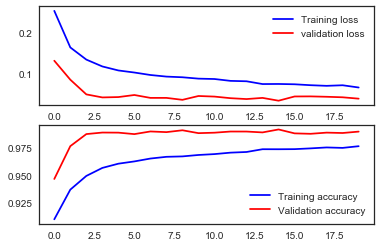

In [119]:
# Build the model
model54 = Sequential()

model54.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model54.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model54.add(MaxPool2D(pool_size=(2,2)))
model54.add(Dropout(0.75))


model54.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model54.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model54.add(Dropout(0.75))

model54.add(Flatten())
model54.add(Dense(256, activation = "relu"))
model54.add(Dropout(0.9))
model54.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model54.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model54.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model54.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

<h2>Compare Learning Rate</h2>

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

#model55 change learning rate from 0.001 to 0.01, the accuracy is lower than model36.

Epoch 1/20
 - 267s - loss: 0.3282 - acc: 0.8998 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 2/20
 - 270s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 3/20
 - 293s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000
Epoch 4/20
 - 288s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 5/20
 - 275s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/20
 - 247s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 7/20
 - 252s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 8/20
 - 266s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3250 - val_acc: 0.9000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 9/20
 - 270s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 10/20
 - 275s - loss: 0.3250 - acc: 0.9000 - val_loss: 0.3249 - val_

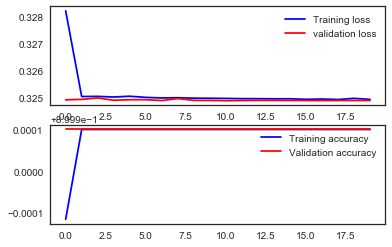

In [120]:
# Build the model
model55 = Sequential()

model55.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model55.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model55.add(MaxPool2D(pool_size=(2,2)))
model55.add(Dropout(0.25))


model55.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model55.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model55.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model55.add(Dropout(0.25))


model55.add(Flatten())
model55.add(Dense(256, activation = "relu"))
model55.add(Dropout(0.5))
model55.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.01, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model55.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model55.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model55.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

#model56 change learning rate from 0.001 to 0.1, the accuracy is lower than model36, and also model55.

Epoch 1/20
 - 215s - loss: 2.8364 - acc: 0.8228 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 2/20
 - 208s - loss: 2.8464 - acc: 0.8224 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 3/20
 - 208s - loss: 2.8547 - acc: 0.8219 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 4/20
 - 209s - loss: 2.8436 - acc: 0.8226 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 5/20
 - 211s - loss: 2.8458 - acc: 0.8225 - val_loss: 2.8384 - val_acc: 0.8229

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
Epoch 6/20
 - 207s - loss: 2.8408 - acc: 0.8228 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 7/20
 - 207s - loss: 2.8432 - acc: 0.8226 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 8/20
 - 208s - loss: 2.8483 - acc: 0.8223 - val_loss: 2.8384 - val_acc: 0.8229

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
Epoch 9/20
 - 209s - loss: 2.8430 - acc: 0.8226 - val_loss: 2.8384 - val_acc: 0.8229
Epoch 10/20
 - 209s - loss: 2.8521 - acc: 0.8221 - val_loss: 2.8384 - val_acc

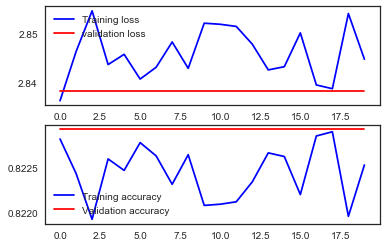

In [121]:
# Build the model
model56 = Sequential()

model56.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model56.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model56.add(MaxPool2D(pool_size=(2,2)))
model56.add(Dropout(0.25))


model56.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model56.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model56.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model56.add(Dropout(0.25))


model56.add(Flatten())
model56.add(Dense(256, activation = "relu"))
model56.add(Dropout(0.5))
model56.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.1, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model56.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model56.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model56.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

<h2>Compare the number of output neurons of dense layer</h2>

#model57 change the output neurons of dense layer from 256 to 512, the accuracy is slightly lower than model36

Epoch 1/20
 - 220s - loss: 0.0673 - acc: 0.9760 - val_loss: 0.0110 - val_acc: 0.9963
Epoch 2/20
 - 215s - loss: 0.0229 - acc: 0.9924 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 3/20
 - 213s - loss: 0.0171 - acc: 0.9942 - val_loss: 0.0091 - val_acc: 0.9972
Epoch 4/20
 - 214s - loss: 0.0140 - acc: 0.9954 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 5/20
 - 215s - loss: 0.0124 - acc: 0.9959 - val_loss: 0.0055 - val_acc: 0.9981
Epoch 6/20
 - 217s - loss: 0.0109 - acc: 0.9965 - val_loss: 0.0057 - val_acc: 0.9983
Epoch 7/20
 - 217s - loss: 0.0105 - acc: 0.9967 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 8/20
 - 214s - loss: 0.0096 - acc: 0.9968 - val_loss: 0.0049 - val_acc: 0.9984
Epoch 9/20
 - 220s - loss: 0.0094 - acc: 0.9968 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 10/20
 - 225s - loss: 0.0088 - acc: 0.9973 - val_loss: 0.0036 - val_acc: 0.9988
Epoch 11/20
 - 219s - loss: 0.0082 - acc: 0.9974 - val_loss: 0.0042 - val_acc: 0.9986
Epoch 12/20
 - 219s - loss: 0.0083 - acc: 0.9973 - val_loss: 0.

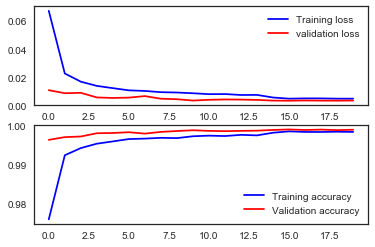

In [122]:
# Build the model
model57 = Sequential()

model57.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model57.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model57.add(MaxPool2D(pool_size=(2,2)))
model57.add(Dropout(0.25))


model57.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model57.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model57.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model57.add(Dropout(0.25))


model57.add(Flatten())
model57.add(Dense(512, activation = "relu"))
model57.add(Dropout(0.5))
model57.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model57.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model57.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model57.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])


#model58 change the output neurons of dense layer from 256 to 128, the accuracy is lower than model36, and also lower than model57

Epoch 1/20
 - 216s - loss: 0.0909 - acc: 0.9682 - val_loss: 0.0140 - val_acc: 0.9954
Epoch 2/20
 - 208s - loss: 0.0307 - acc: 0.9899 - val_loss: 0.0101 - val_acc: 0.9964
Epoch 3/20
 - 217s - loss: 0.0219 - acc: 0.9926 - val_loss: 0.0088 - val_acc: 0.9973
Epoch 4/20
 - 267s - loss: 0.0190 - acc: 0.9937 - val_loss: 0.0086 - val_acc: 0.9974
Epoch 5/20
 - 224s - loss: 0.0164 - acc: 0.9948 - val_loss: 0.0079 - val_acc: 0.9976
Epoch 6/20
 - 232s - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0069 - val_acc: 0.9977
Epoch 7/20
 - 214s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0064 - val_acc: 0.9982
Epoch 8/20
 - 242s - loss: 0.0133 - acc: 0.9960 - val_loss: 0.0061 - val_acc: 0.9981
Epoch 9/20
 - 209s - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0062 - val_acc: 0.9978
Epoch 10/20
 - 229s - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0053 - val_acc: 0.9984
Epoch 11/20
 - 211s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 12/20
 - 211s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.

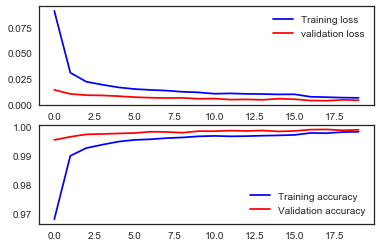

In [124]:
# Build the model
model58 = Sequential()

model58.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model58.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model58.add(MaxPool2D(pool_size=(2,2)))
model58.add(Dropout(0.25))


model58.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model58.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model58.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model58.add(Dropout(0.25))


model58.add(Flatten())
model58.add(Dense(128, activation = "relu"))
model58.add(Dropout(0.5))
model58.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model58.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model58.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model58.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

<h2>Compare padding</h2>

padding: One of "valid", "causal" or "same" (case-insensitive). "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input. "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order. 

#model59 use padding = 'valid'

Epoch 1/20
 - 110s - loss: 0.1014 - acc: 0.9641 - val_loss: 0.0132 - val_acc: 0.9954
Epoch 2/20
 - 98s - loss: 0.0341 - acc: 0.9885 - val_loss: 0.0098 - val_acc: 0.9968
Epoch 3/20
 - 99s - loss: 0.0236 - acc: 0.9920 - val_loss: 0.0068 - val_acc: 0.9976
Epoch 4/20
 - 96s - loss: 0.0194 - acc: 0.9936 - val_loss: 0.0060 - val_acc: 0.9980
Epoch 5/20
 - 107s - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 6/20
 - 113s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 7/20
 - 103s - loss: 0.0140 - acc: 0.9957 - val_loss: 0.0056 - val_acc: 0.9982
Epoch 8/20
 - 102s - loss: 0.0126 - acc: 0.9959 - val_loss: 0.0049 - val_acc: 0.9983
Epoch 9/20
 - 95s - loss: 0.0122 - acc: 0.9959 - val_loss: 0.0054 - val_acc: 0.9983
Epoch 10/20
 - 94s - loss: 0.0117 - acc: 0.9962 - val_loss: 0.0048 - val_acc: 0.9985
Epoch 11/20
 - 94s - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0045 - val_acc: 0.9985
Epoch 12/20
 - 94s - loss: 0.0110 - acc: 0.9966 - val_loss: 0.0050 - 

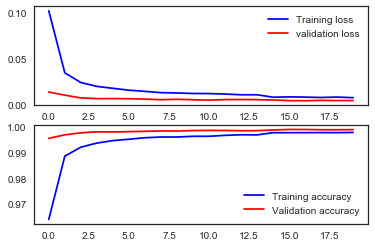

In [125]:
# Build the model
model59 = Sequential()

model59.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (28,28,1), kernel_initializer='glorot_uniform'))
model59.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model59.add(MaxPool2D(pool_size=(2,2)))
model59.add(Dropout(0.25))


model59.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model59.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu', kernel_initializer='glorot_uniform'))
model59.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model59.add(Dropout(0.25))


model59.add(Flatten())
model59.add(Dense(256, activation = "relu"))
model59.add(Dropout(0.5))
model59.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = Nadam(lr=0.001, epsilon=1e-08, schedule_decay=0.004)

# Compile the model
model59.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 20
batch_size = 86

import time 
t1=time.time()
history = model59.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
t = time.time()-t1 
print("running time is %g s" %(t)) 


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


score = model59.evaluate(X_val,Y_val, verbose=0)
print('validation loss:', score[0])
print('validation accuracy:', score[1])

Through comparation, padding = 'same' get the higher accuracy.